# Noise Robustness of PySINDy

PySINDy is designed to identify dynamic systems. In real world applications, it is not guaranteed that no noise exists in oberved measurements from expriments. Thus, it is important to understand how well PySINDy identifies different systems with various level of noise. 

This note book examines PySINDy's noise robustness with two aspects, **Noisy** and **Chaotic** level, by two performance measurements **RMSE** and **Normalized Error**. The performances are visulized by contour plots.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets

# Annoyingly requires the neurokit2 package - "pip install neurokit2"
from dysts.analysis import sample_initial_conditions

import pysindy as ps

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Seed the random number generators for reproducibility
np.random.seed(100)

# Chaotic System Initialization

This experiment include 19 chaotic systems are *"Aizawa", "AnishchenkoAstakhov", "Arneodo", "Blasius", "Bouali", "CaTwoPlus", "GenesioTesi", "HenonHeiles", "HyperBao", "HyperCai", "HyperJha", "HyperLorenz", "HyperLu", "HyperPang", "Laser", "Lorenz", "LorenzBounded", "MooreSpiegel", "Rossler", "ShimizuMorioka"*, provided by William Gilpin. "Chaos as an interpretable benchmark for forecasting and data-driven modelling" Advances in Neural Information Processing Systems (NeurIPS) 2021 https://arxiv.org/abs/2110.05266.

According to *Gilpin*, the above four standard mathematicl charactristics of chaotic systems are defined as:

> The **largest Lyapunov exponent** measures the degree to which nearby trajectories diverge, a common
measure of the degree of chaos present in a system;

> The **correlation dimension** measures an attractor’s effective fractal dimension, which informally
indicates the intricacy of its geometric structure;

> The **Kaplan-Yorke Dimension** is an alternative fractal dimension, a measure of geometric complexity;

> The **multiscale entropy** represents the degree to which complex dynamics persist across timescales.

This section precompute the time-series trajectory data of experimental systems and systems' attributes that describes the complexity of systems, including **Estimated Maximum Lyapunov Exponent**, **Kaplan Yorke Dimension**, **Multiscale Entropy**, and **Correlation Dimension**.

In [2]:
# experimental system list
systems_list = ["Aizawa", "AnishchenkoAstakhov", "Arneodo", "Blasius", "Bouali", 
                "CaTwoPlus", "GenesioTesi", "HyperBao", "HyperCai",
                "HyperJha", "HyperLorenz", "HyperLu", "HyperPang", "Laser",
                "Lorenz", "LorenzBounded", "MooreSpiegel", "Rossler", "ShimizuMorioka"]

# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "kaplan_yorke_dimension",
    "multiscale_entropy",
    "correlation_dimension",
]

# Get training and testing trajectories for all the experimental systems and their attributes
n = 2000
all_sols_train = dict()
all_sols_test = dict()
all_t_train = dict()
all_t_test = dict()
all_properties = dict()

for equation_name in systems_list:
    eq = getattr(flows, equation_name)()
    try:
        ic_train, ic_test = sample_initial_conditions(eq, 2, traj_length=1000, pts_per_period=30)
        eq.ic = ic_train
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=True, return_times=True, standardize=False)
        all_sols_train[equation_name] = sol
        all_t_train[equation_name] = t_sol
        eq.ic = ic_test
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=True, return_times=True, standardize=False)
        all_sols_test[equation_name] = sol
        all_t_test[equation_name] = t_sol
        attr_vals = [getattr(eq, item, None) for item in attributes]
        all_properties[equation_name] = dict(zip(attributes, attr_vals))
    except SystemError:
        print('Could not load one of the systems: ', equation_name)
    except TypeError:
        print('Could not load one of the systems ', equation_name)

## Trajectory Visualization

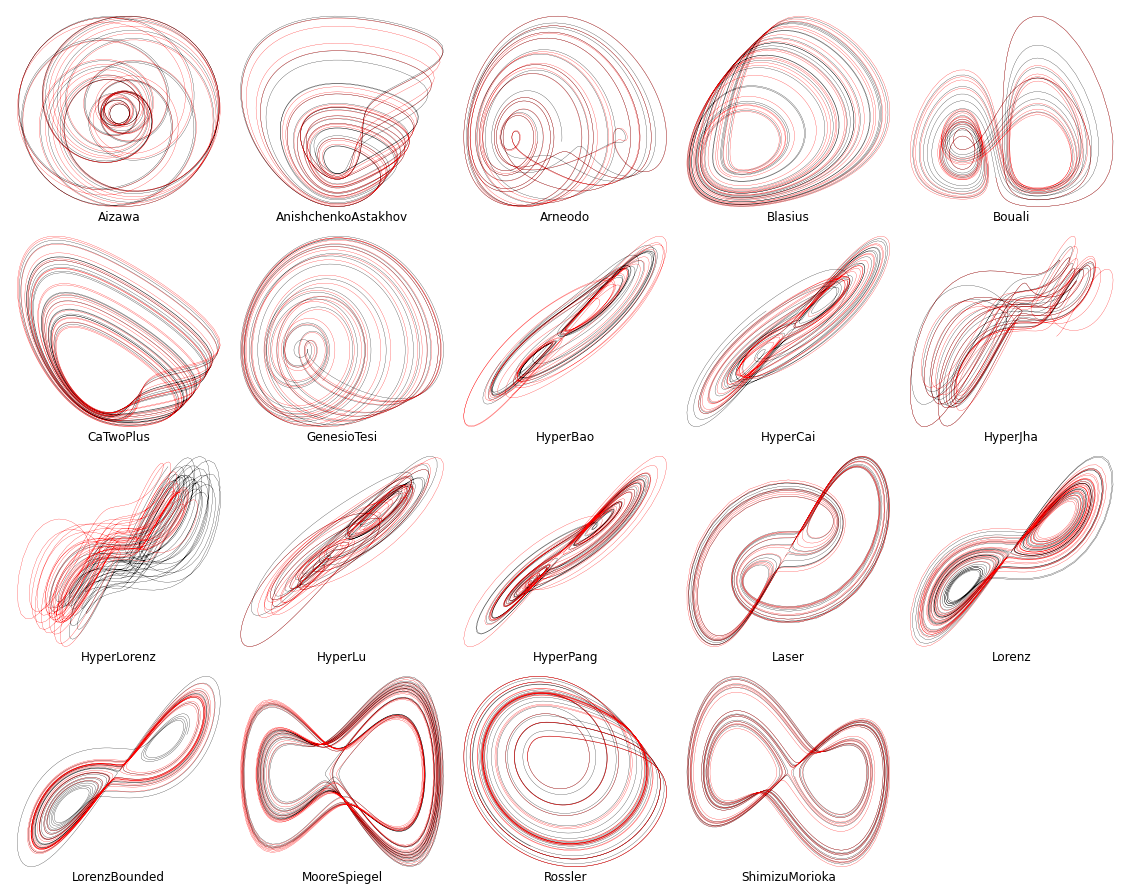

In [33]:
# Plot the training and testing trajectories for all the chaotic systems
num_cols = 5
num_rows = int(np.ceil(len(all_sols_train) / num_cols))
fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.05) 

for i, attractor_name in enumerate(all_sols_train):
    
    x_train = all_sols_train[attractor_name]
    x_test = all_sols_test[attractor_name]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    plt.subplot(gs[i])
    plt.plot(x_train[:, 0], x_train[:, 1], 'k', linewidth=0.25)
    plt.plot(x_test[:, 0], x_test[:, 1], 'r', linewidth=0.25)
    plt.title(attractor_name, y=-0.05)
    plt.gca().axis('off')

## Distribution of Chaotic Properties

Visulizes the distribution of the above four key properties of the 19 chaotic system.

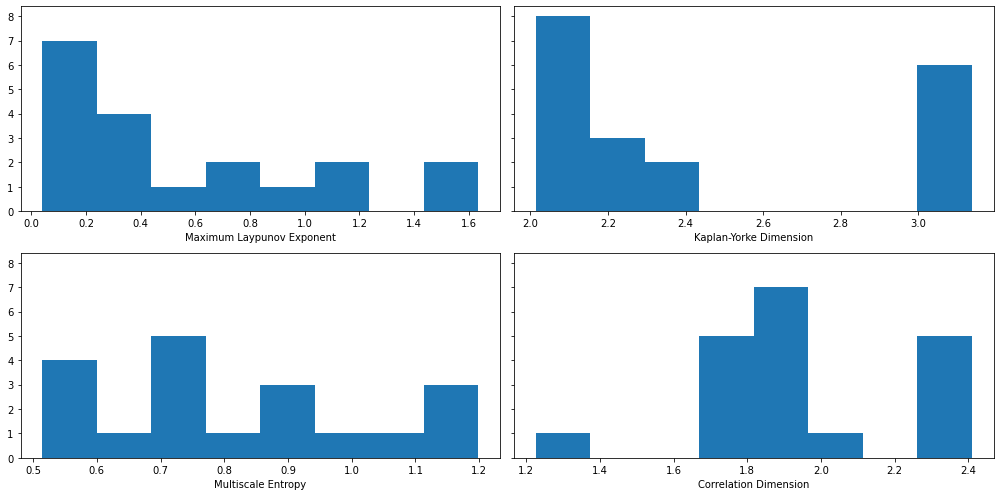

In [32]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 7)
# extract measurements
lyap_list = []
kap_list = []
ent_list = []
dim_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])
    kap_list.append(all_properties[system]['kaplan_yorke_dimension'])
    ent_list.append(all_properties[system]['multiscale_entropy'])
    dim_list.append(all_properties[system]['correlation_dimension'])
    
# plot distribution with curve
fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)

## maximum lyapunov estimated
axs[0, 0].hist(lyap_list, bins=8)
axs[0, 0].set(xlabel='Maximum Laypunov Exponent')

## kaplan-yorke dimension
axs[0, 1].hist(kap_list, bins=8)
axs[0, 1].set(xlabel='Kaplan-Yorke Dimension')

## multiscale entropy
axs[1, 0].hist(ent_list, bins=8)
axs[1, 0].set(xlabel='Multiscale Entropy')

## multiscale entropy
axs[1, 1].hist(dim_list, bins=8)
axs[1, 1].set(xlabel='Correlation Dimension')

fig.show()

# Algorithm 2 from Rudy et al. (2017) 

Algorithm 2 is implemented here for scanning the thresholds passed to the STLSQ optimizer (which actually defaults to Ridge Regression with the $l_0$ norm). This hyperparameter scanning is required if we are trying to fit many systems at once, which will have many different physical scales.

In [34]:
# Algorithm to scan over threshold values during Ridge Regression, and select
# highest performing model on the test set

def rudy_algorithm2(x_train, x_test, t_train, ode_lib, dtol, alpha=1e-5, 
                    tol_iter=25, change_factor=2, l0_pen=1e-3,
                    normalize_columns=True, optimizer_max_iter=20):  
    
    # Do an initial least-squares fit to get an initial guess of the coefficients
    optimizer = ps.STLSQ(threshold=0, alpha=0, 
                         max_iter=optimizer_max_iter, 
                         normalize_columns=normalize_columns, 
                         ridge_kw={'tol': 1e-10})
    
    # Compute initial model
    model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
    model.fit(x_train, t=t_train)
    
    # Set the L0 penalty based on the condition number of Theta
    l0_penalty = l0_pen * np.linalg.cond(optimizer.Theta_)
    coef_best = optimizer.coef_
    
    # Compute MSE on the testing x_dot data (takes x_test and computes x_dot_test)
    error_best = model.score(x_test, metric=mean_squared_error, squared=False
                            ) + l0_penalty * np.count_nonzero(coef_best)
    
    coef_history_ = np.zeros((coef_best.shape[0], coef_best.shape[1], 1 + tol_iter))
    error_history_ = np.zeros(1 + tol_iter)
    coef_history_[:, :, 0] = coef_best
    error_history_[0] = error_best
    tol = dtol
    
    # Loop over threshold values, note needs some coding 
    # if not using STLSQ optimizer
    for i in range(tol_iter):
        optimizer = ps.STLSQ(threshold=tol, alpha=alpha, 
                             max_iter=optimizer_max_iter,
                             normalize_columns=normalize_columns, 
                             ridge_kw={'tol': 1e-10})
        model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
        model.fit(x_train, t=t_train)
        coef_new = optimizer.coef_
        coef_history_[:, :, i + 1] = coef_new
        error_new = model.score(x_test, metric=mean_squared_error, squared=False
                               ) + l0_penalty * np.count_nonzero(coef_new)
        error_history_[i + 1] = error_new
        
        # If error improves, set the new best coefficients
        if error_new <= error_best:
            error_best = error_new
            coef_best = coef_new
            tol += dtol
            #tol *= change_factor
        else:
            #tol = tol / (change_factor * 1.1)
            tol = max(0, tol - change_factor * dtol)
            dtol = change_factor * dtol / (tol_iter - i)
            tol += dtol
    return coef_best, error_best, coef_history_, error_history_, model

# Compute Predicted Trajectory with Increasing Noisy Level

In this section, we will compute and record the model performance, both RMSE and Normalized Error for 19 systems with 13 noise levels each system. Considering the randomness of noise, we repeat each case for 20 times for averaged values. 

In total, this section produces 9880 measurements (RMSE and Normalized Error).

## Define performance calculator

In [ ]:
def get_perf(x_true, x_pred):
    """
    Given true trajectory and predicted trajectory, compute the
    performance score by formular defined in the top section.
    """
    numer = np.linalg.norm(x_true - x_pred)
    domin = np.linalg.norm(x_true)
    return numer / domin

## Compute RMSEs and Normalized Errors

In [5]:
# define data structure for records
x_rmse_dic = {}  # key: system name, value: list of rmses
dot_rmse_dic = {}  # key: system name, value: list of rmses

x_perf_dic = {}  # key: system name, value: list of normalized errors
dot_perf_dic = {}  # key: system name, value: liss of normalized errors

# initialize sturctures
for system in systems_list:
    x_rmse_dic[system] = list()
    x_perf_dic[system] = list()
    dot_rmse_dic[system] = list()
    dot_perf_dic[system] = list()

In [6]:
denom_list = [5, 7, 9]
for i in range(10, 101, 10):
    denom_list.append(i)

In [ ]:
# iterate over all systems and noise levels
for attractor_name in systems_list:
    print("-----------------------------------------------")
    print("--------------", attractor_name, "--------------")
    print("-----------------------------------------------")

    x_train = all_sols_train[attractor_name]
    x_test = all_sols_test[attractor_name]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    max_iter = 2
    tol_iter = 2
    
    # noise variance controller
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
    
    for denominator in denom_list:
        # multiple test for averaged results
        for j in range(20):
            # contruct noisy data
            x_train_noisy = x_train + np.random.normal(0, rmse / denominator, x_train.shape)
            
            # define library for pysindy
            poly_library = ps.PolynomialLibrary(degree=4)
            fourier_library = ps.FourierLibrary()
            concat_library = poly_library + fourier_library
            
            # rudy train
            coef_best, err_best, coef_history, err_history, model = rudy_algorithm2(
                x_train_noisy, x_test, t_train,
                ode_lib=concat_library, dtol=1e-3,
                optimizer_max_iter=30,
                tol_iter=tol_iter,
                change_factor=2,
                l0_pen=1e-1
            )

            # predict x and x_dot
            x_dot_test = model.differentiate(x_test, t=t_test)
            x_dot_test_pred = model.predict(x_test)
            x_test_pred = model.simulate(x_test[0, :], t=t_test, integrator="odeint",
                                         integrator_kws={"mxstep":30})
            
            # compute and record rmses
            x_rmse_in_dic[attractor_name].append(mean_squared_error(x_test, x_test_pred, squared=False))
            dot_rmse_in_dic[attractor_name].append(mean_squared_error(x_dot_test, x_dot_test_pred, squared=False))
            
            # compute and record normalized errors
            x_perf_in_dic[attractor_name].append(get_perf(x_test, x_test_pred))
            dot_perf_in_dic[attractor_name].append(get_perf(x_dot_test, x_dot_test_pred))

-----------------------------------------------
-------------- Aizawa --------------
-----------------------------------------------
-----------------------------------------------
-------------- AnishchenkoAstakhov --------------
-----------------------------------------------
-----------------------------------------------
-------------- Arneodo --------------
-----------------------------------------------
-----------------------------------------------
-------------- Blasius --------------
-----------------------------------------------
-----------------------------------------------
-------------- Bouali --------------
-----------------------------------------------
-----------------------------------------------
-------------- CaTwoPlus --------------
-----------------------------------------------


/Users/zhanglanyue/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.22279e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/zhanglanyue/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.22279e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/zhanglanyue/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.22279e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/zhanglanyue/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.1612e-18): result may not be accurate.
  return linalg.solve(A,

-----------------------------------------------
-------------- GenesioTesi --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperBao --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperCai --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperJha --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperLorenz --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperLu --------------
-----------------------------------------------
-----------------------------------------------
-------------- HyperPang --------------
-----------------------------------------------
-----------------------------------------------
-

## Save new results to JSON


In [ ]:
# uncomment the following code to save as JSON
"""
import json
with open('x_perf_in_dic.json', 'w') as f:
    json.dump(x_perf_in_dic, f)
    
with open('x_rmse_in_dic.json', 'w') as f:
    json.dump(x_rmse_in_dic, f)
    
with open('dot_perf_in_dic.json', 'w') as f:
    json.dump(dot_perf_in_dic, f)
    
with open('dot_rmse_in_dic.json', 'w') as f:
    json.dump(dot_rmse_in_dic, f)
"""

In [21]:
# uncomment the following code to read from JSON
"""
temp = open('x_rmse_in_dic.json')
x_rmse_in_dic = json.load(temp)

temp = open('x_perf_in_dic.json')
x_perf_in_dic = json.load(temp)

temp = open('dot_rmse_in_dic.json')
dot_rmse_in_dic = json.load(temp)

temp = open('dot_perf_in_dic.json')
dot_perf_in_dic = json.load(temp)
""

# Data Preparation

This section does two things: 1. filter the outliers due to edge cases; 2. compute the average performance of each noisy level per system.

To make sure the filter is not removing measurements too aggresively, we use boxplots to check the distribution of  performance measurements. There will be 4 sets of before-and-after boxplots: RMSE and Normalized Error for original trajectory, 2 for derivative trajectory.

In [ ]:
x_rmse_dic = x_rmse_in_dic
x_perf_dic = x_perf_in_dic

dot_rmse_dic = dot_rmse_in_dic
dot_perf_dic = dot_perf_in_dic

In [ ]:
# define method for each system
def outlier_filter(data):
    """
    Compute the average value of the given list with outliers filtered.
    """
    result = []
    
    for i in range(int(len(data) / 20)):
        curr = data[i * 20 : (i+1) * 20]
        
        # IQR
        Q1 = np.percentile(curr, 25, interpolation = 'midpoint')
        Q3 = np.percentile(curr, 75, interpolation = 'midpoint')
        IQR = Q3 - Q1

        # upper and lower bound
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5 * IQR
        
        temp = []
        
        # filter by bounds
        for value in curr:
            if value < upper and value > lower:
                temp.append(value)
                
        result.append(sum(temp) / len(temp))
    
    return result

## RMSE for origin and derivatives before filter

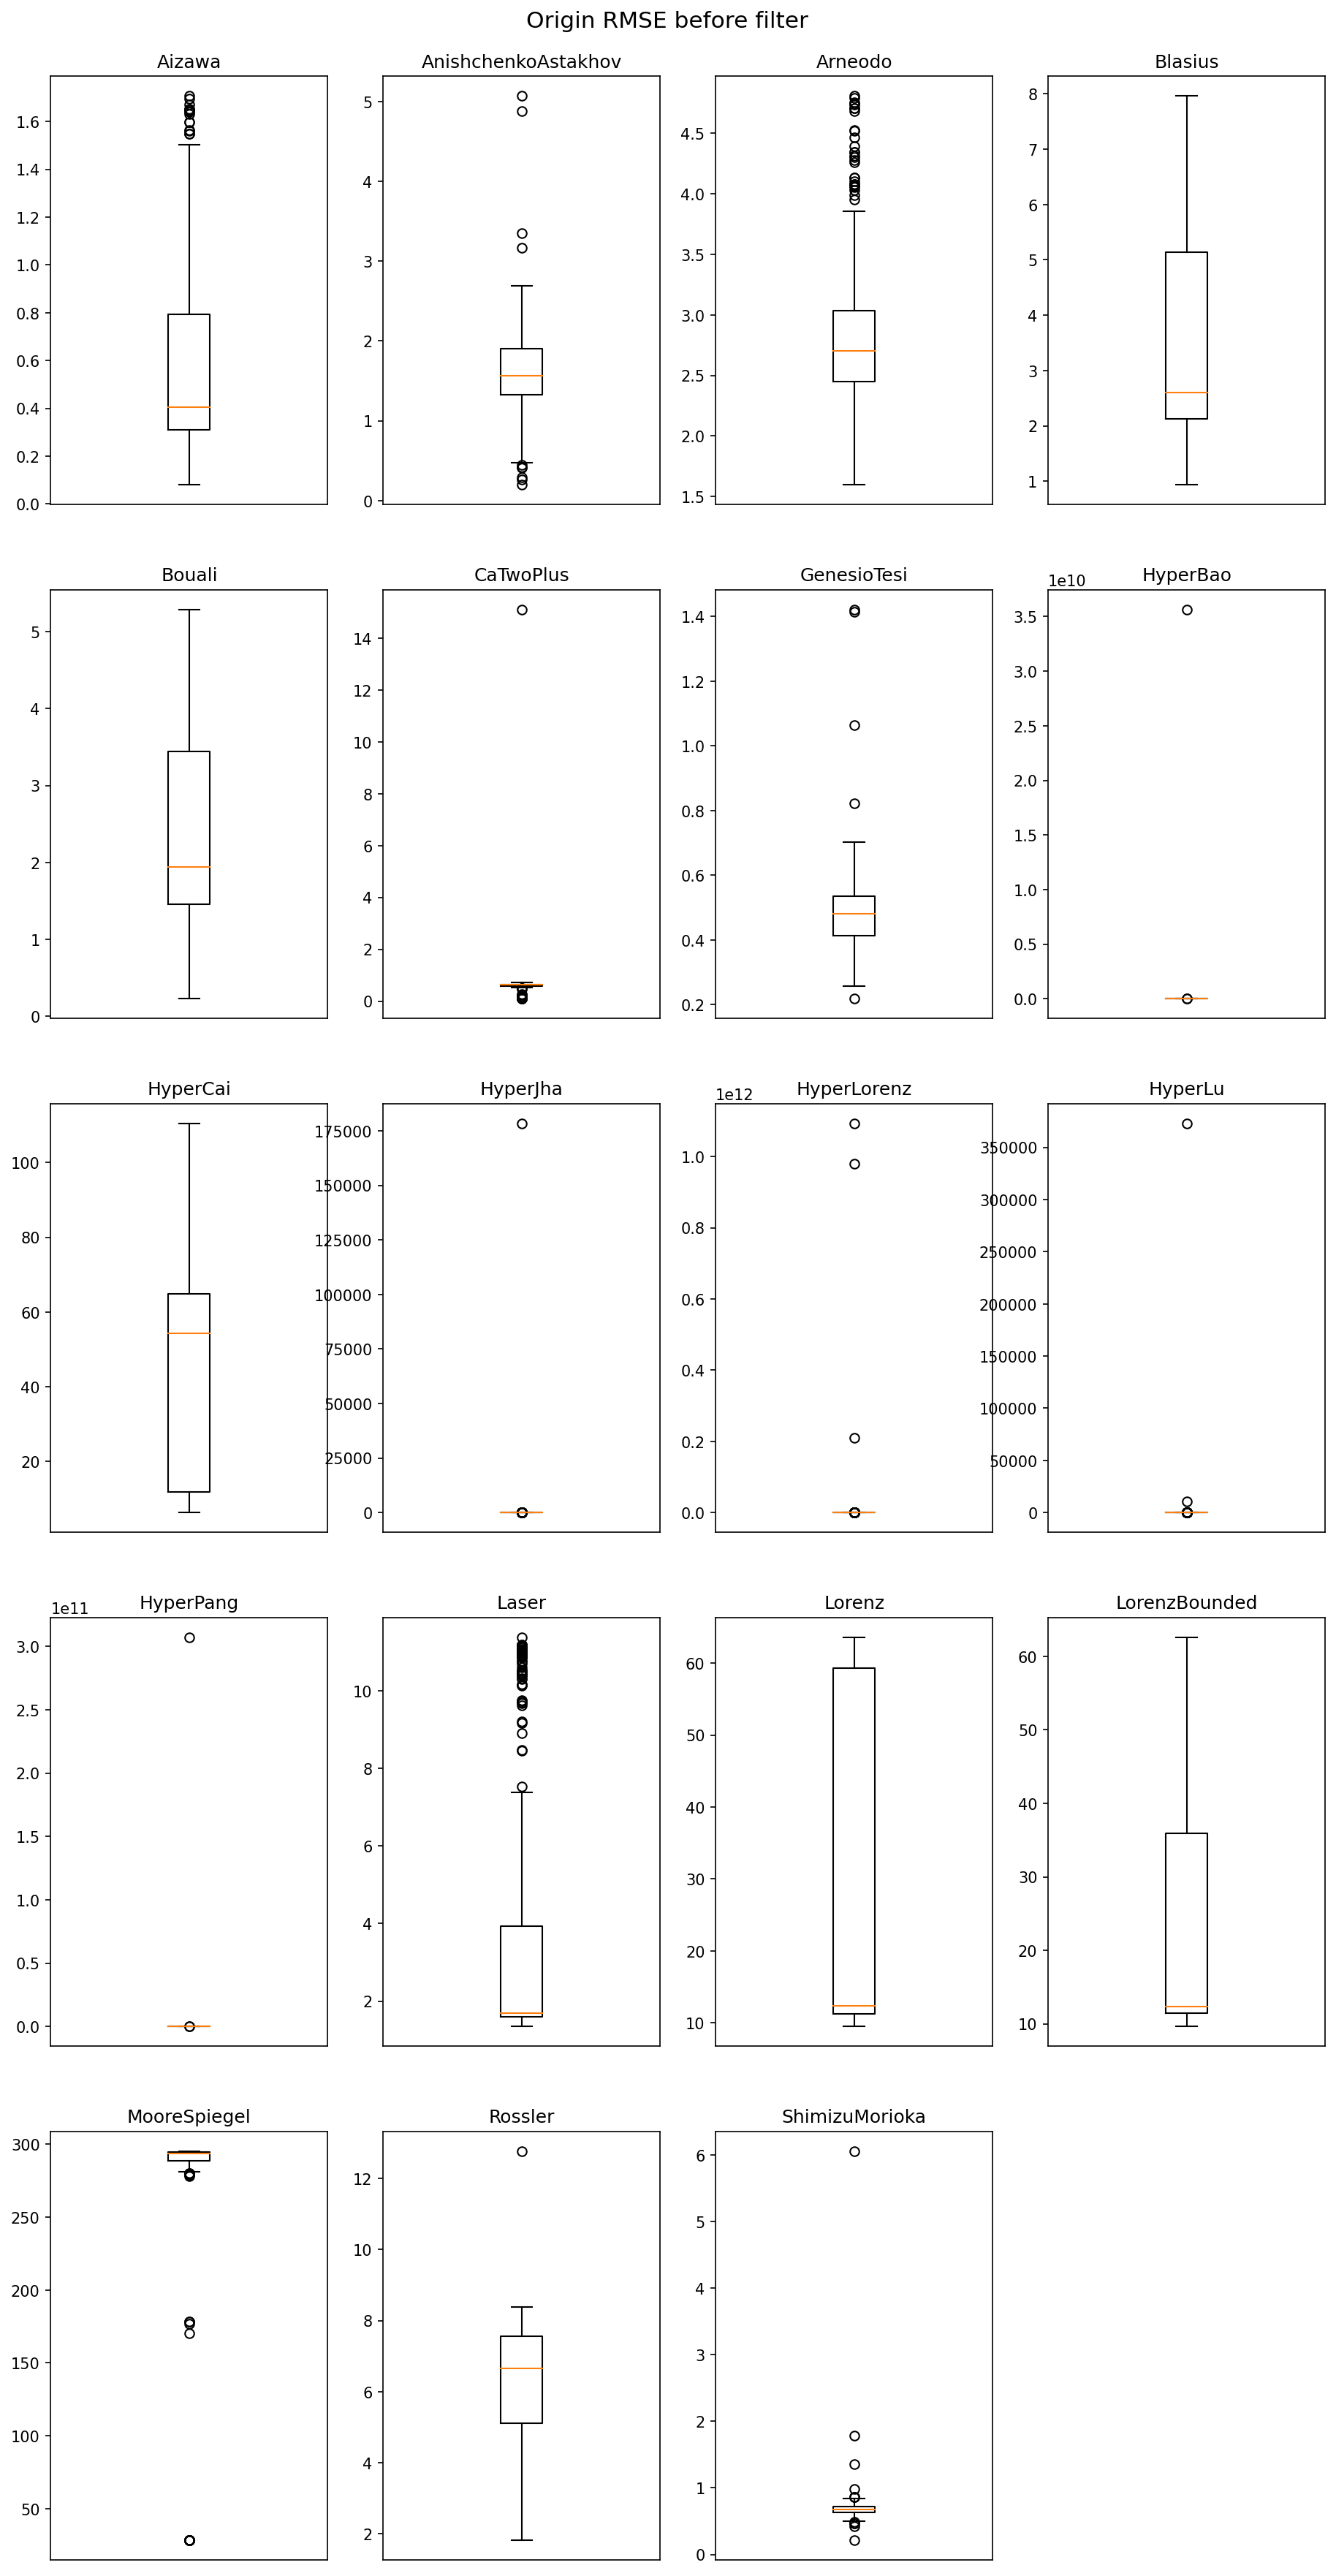

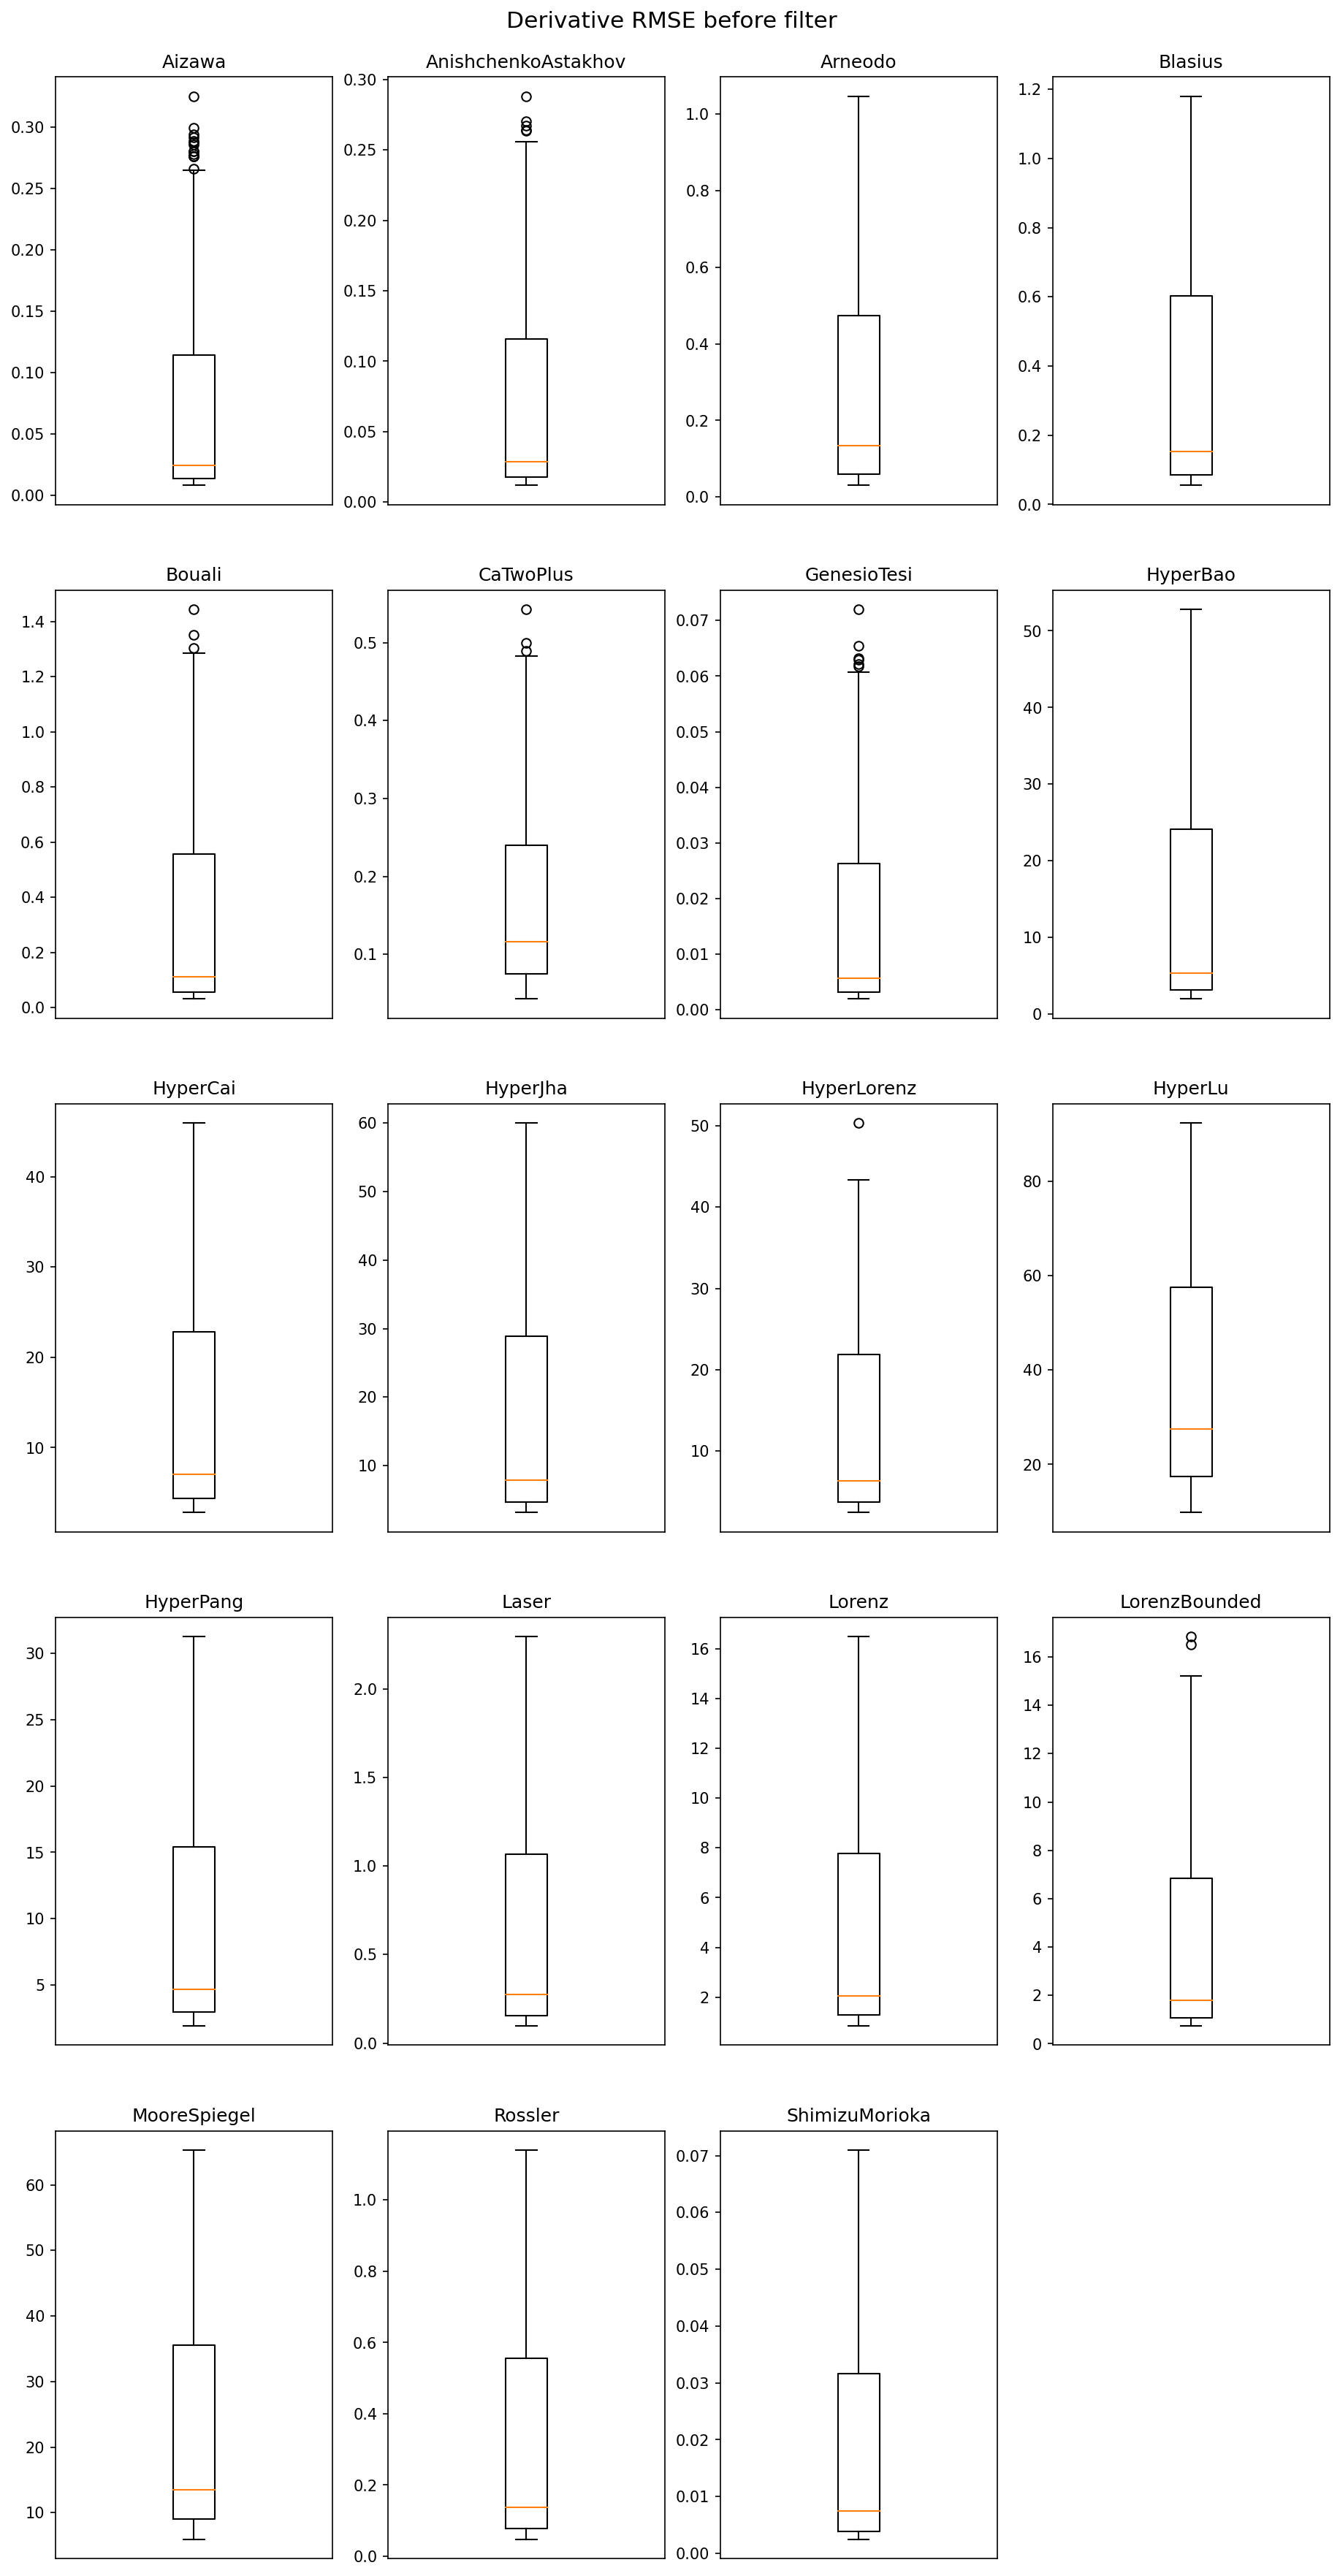

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# boxplots before filter
fig, axs = plt.subplots(5, 4, figsize=(15,30))
fig.delaxes(axs[4, 3])
fig.suptitle('Origin RMSE before filter', fontsize=15, y=0.9)
fig.set_dpi(150)

for idx, system in enumerate(systems_list):
    axs[int(idx / 4), idx % 4].boxplot(x_rmse_dic[system])
    axs[int(idx / 4), idx % 4].set_title(system)
    axs[int(idx / 4), idx % 4].set_xticks([], [])

fig, axs = plt.subplots(5, 4, figsize=(15,30))
fig.delaxes(axs[4, 3])
fig.suptitle('Derivative RMSE before filter', fontsize=15, y=0.9)
fig.set_dpi(150)

for idx, system in enumerate(systems_list):
    axs[int(idx / 4), idx % 4].boxplot(dot_rmse_dic[system])
    axs[int(idx / 4), idx % 4].set_title(system)
    axs[int(idx / 4), idx % 4].set_xticks([], [])


## RMSE for origin and derivatives after filter

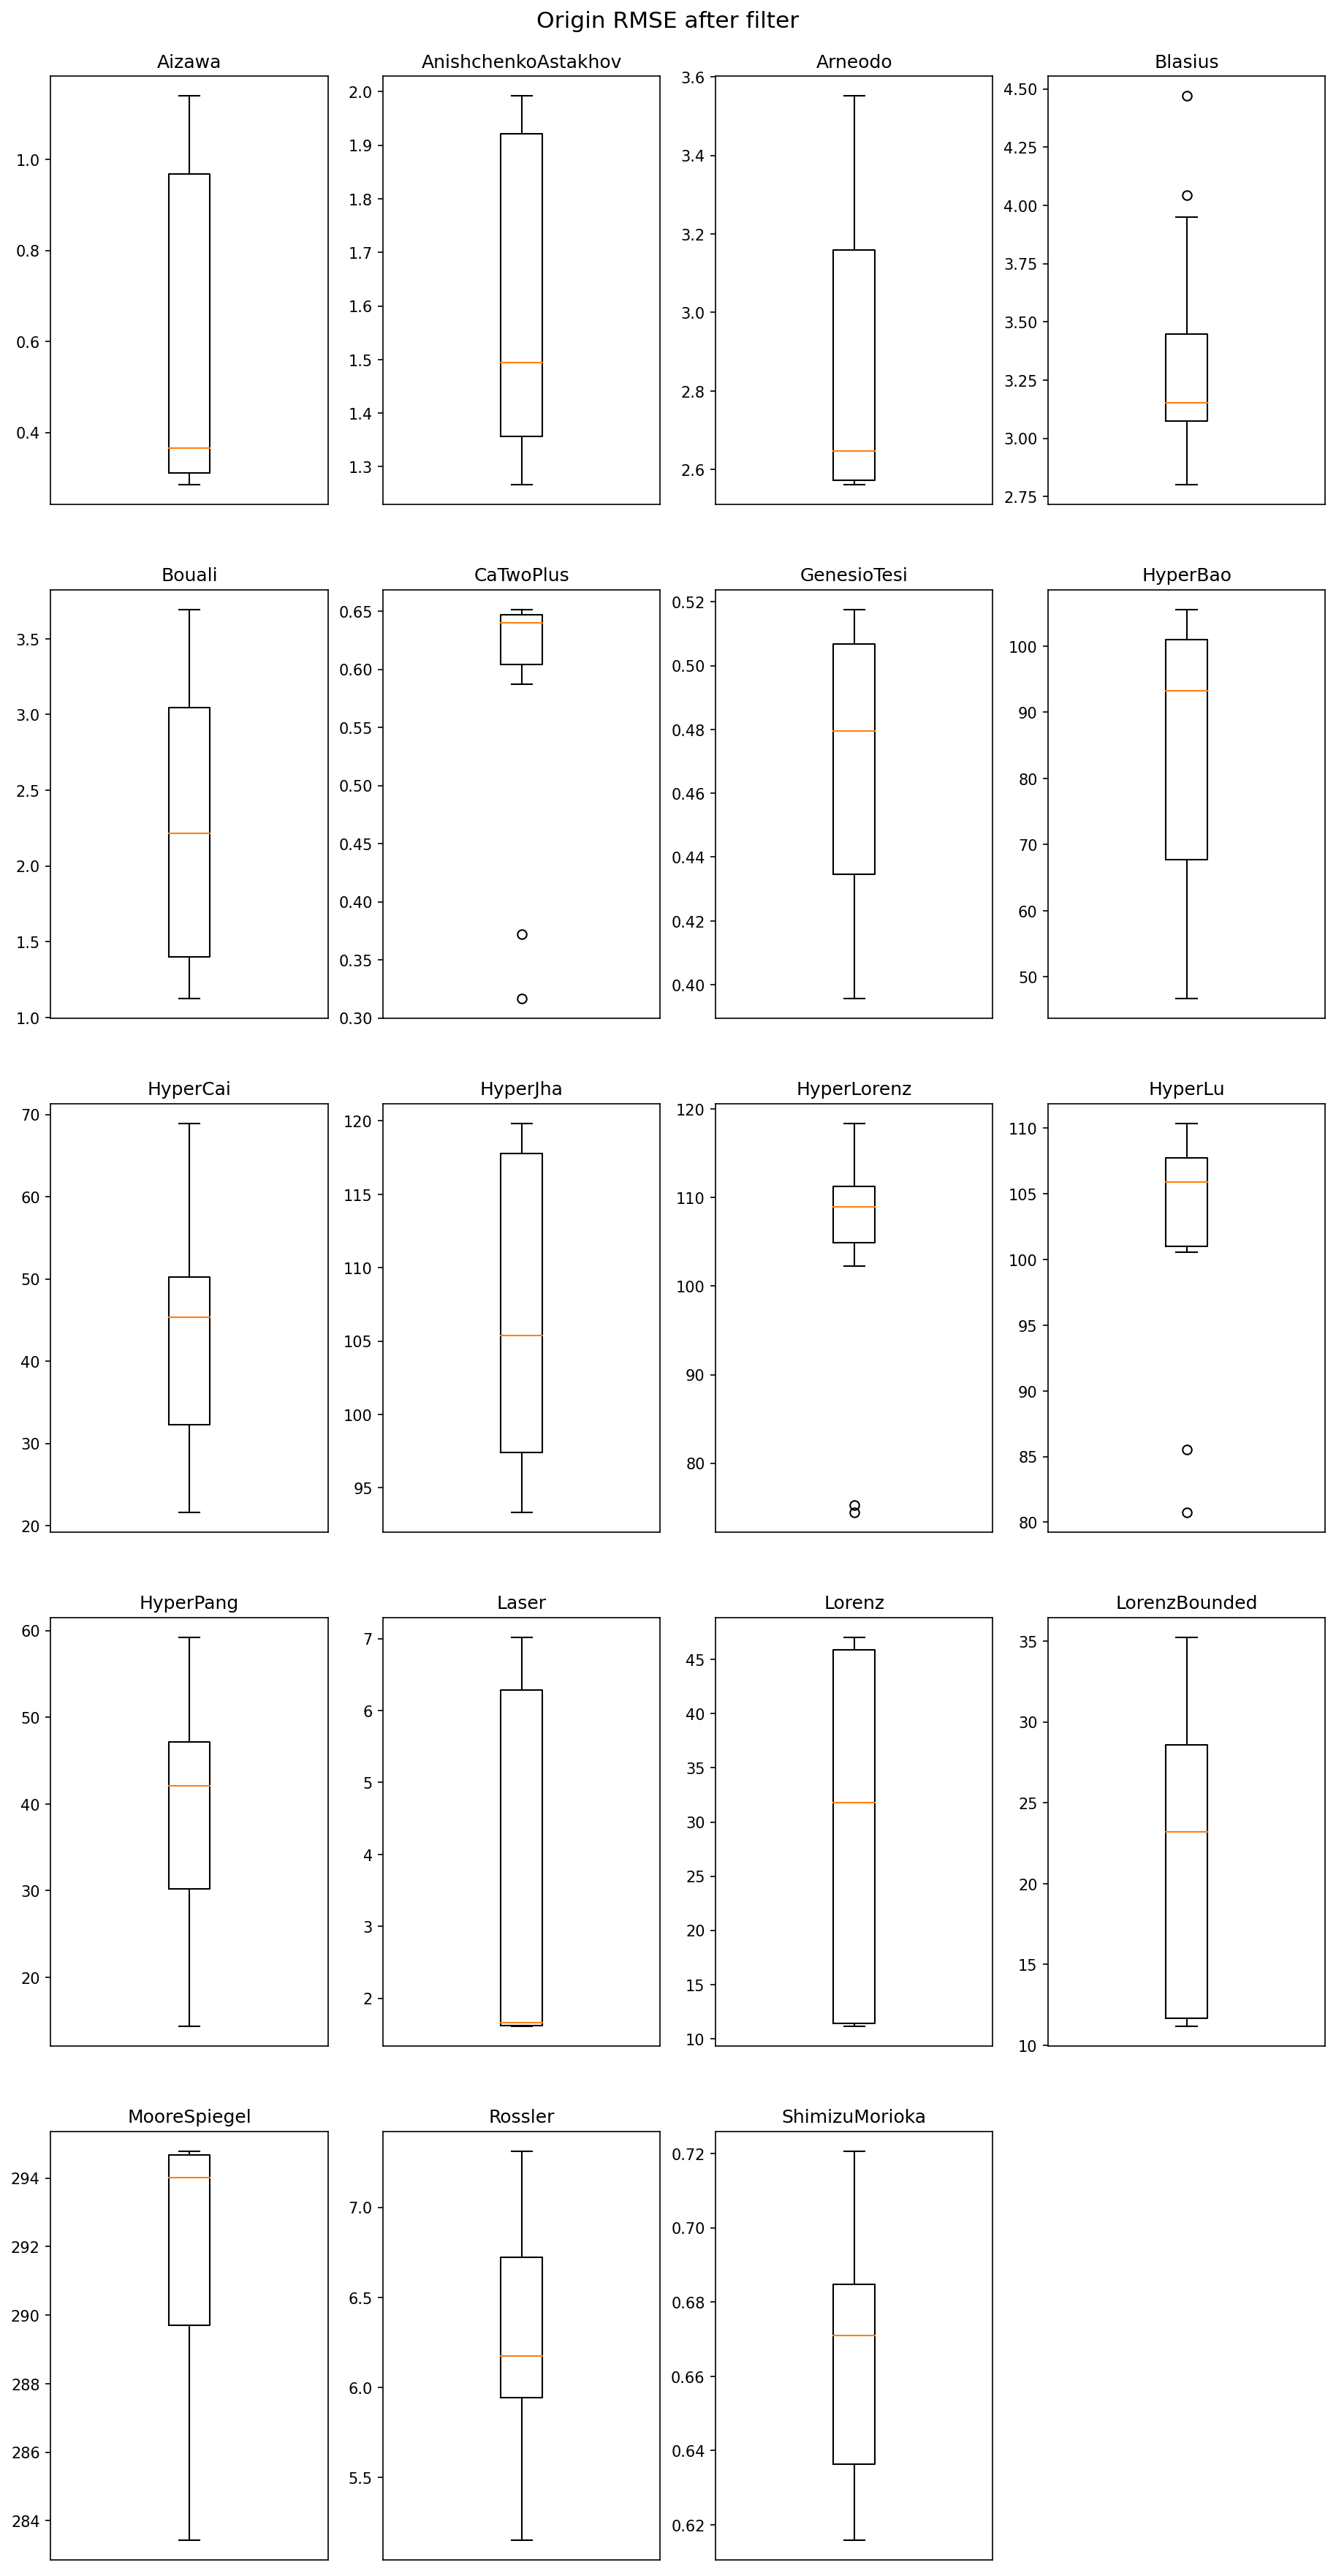

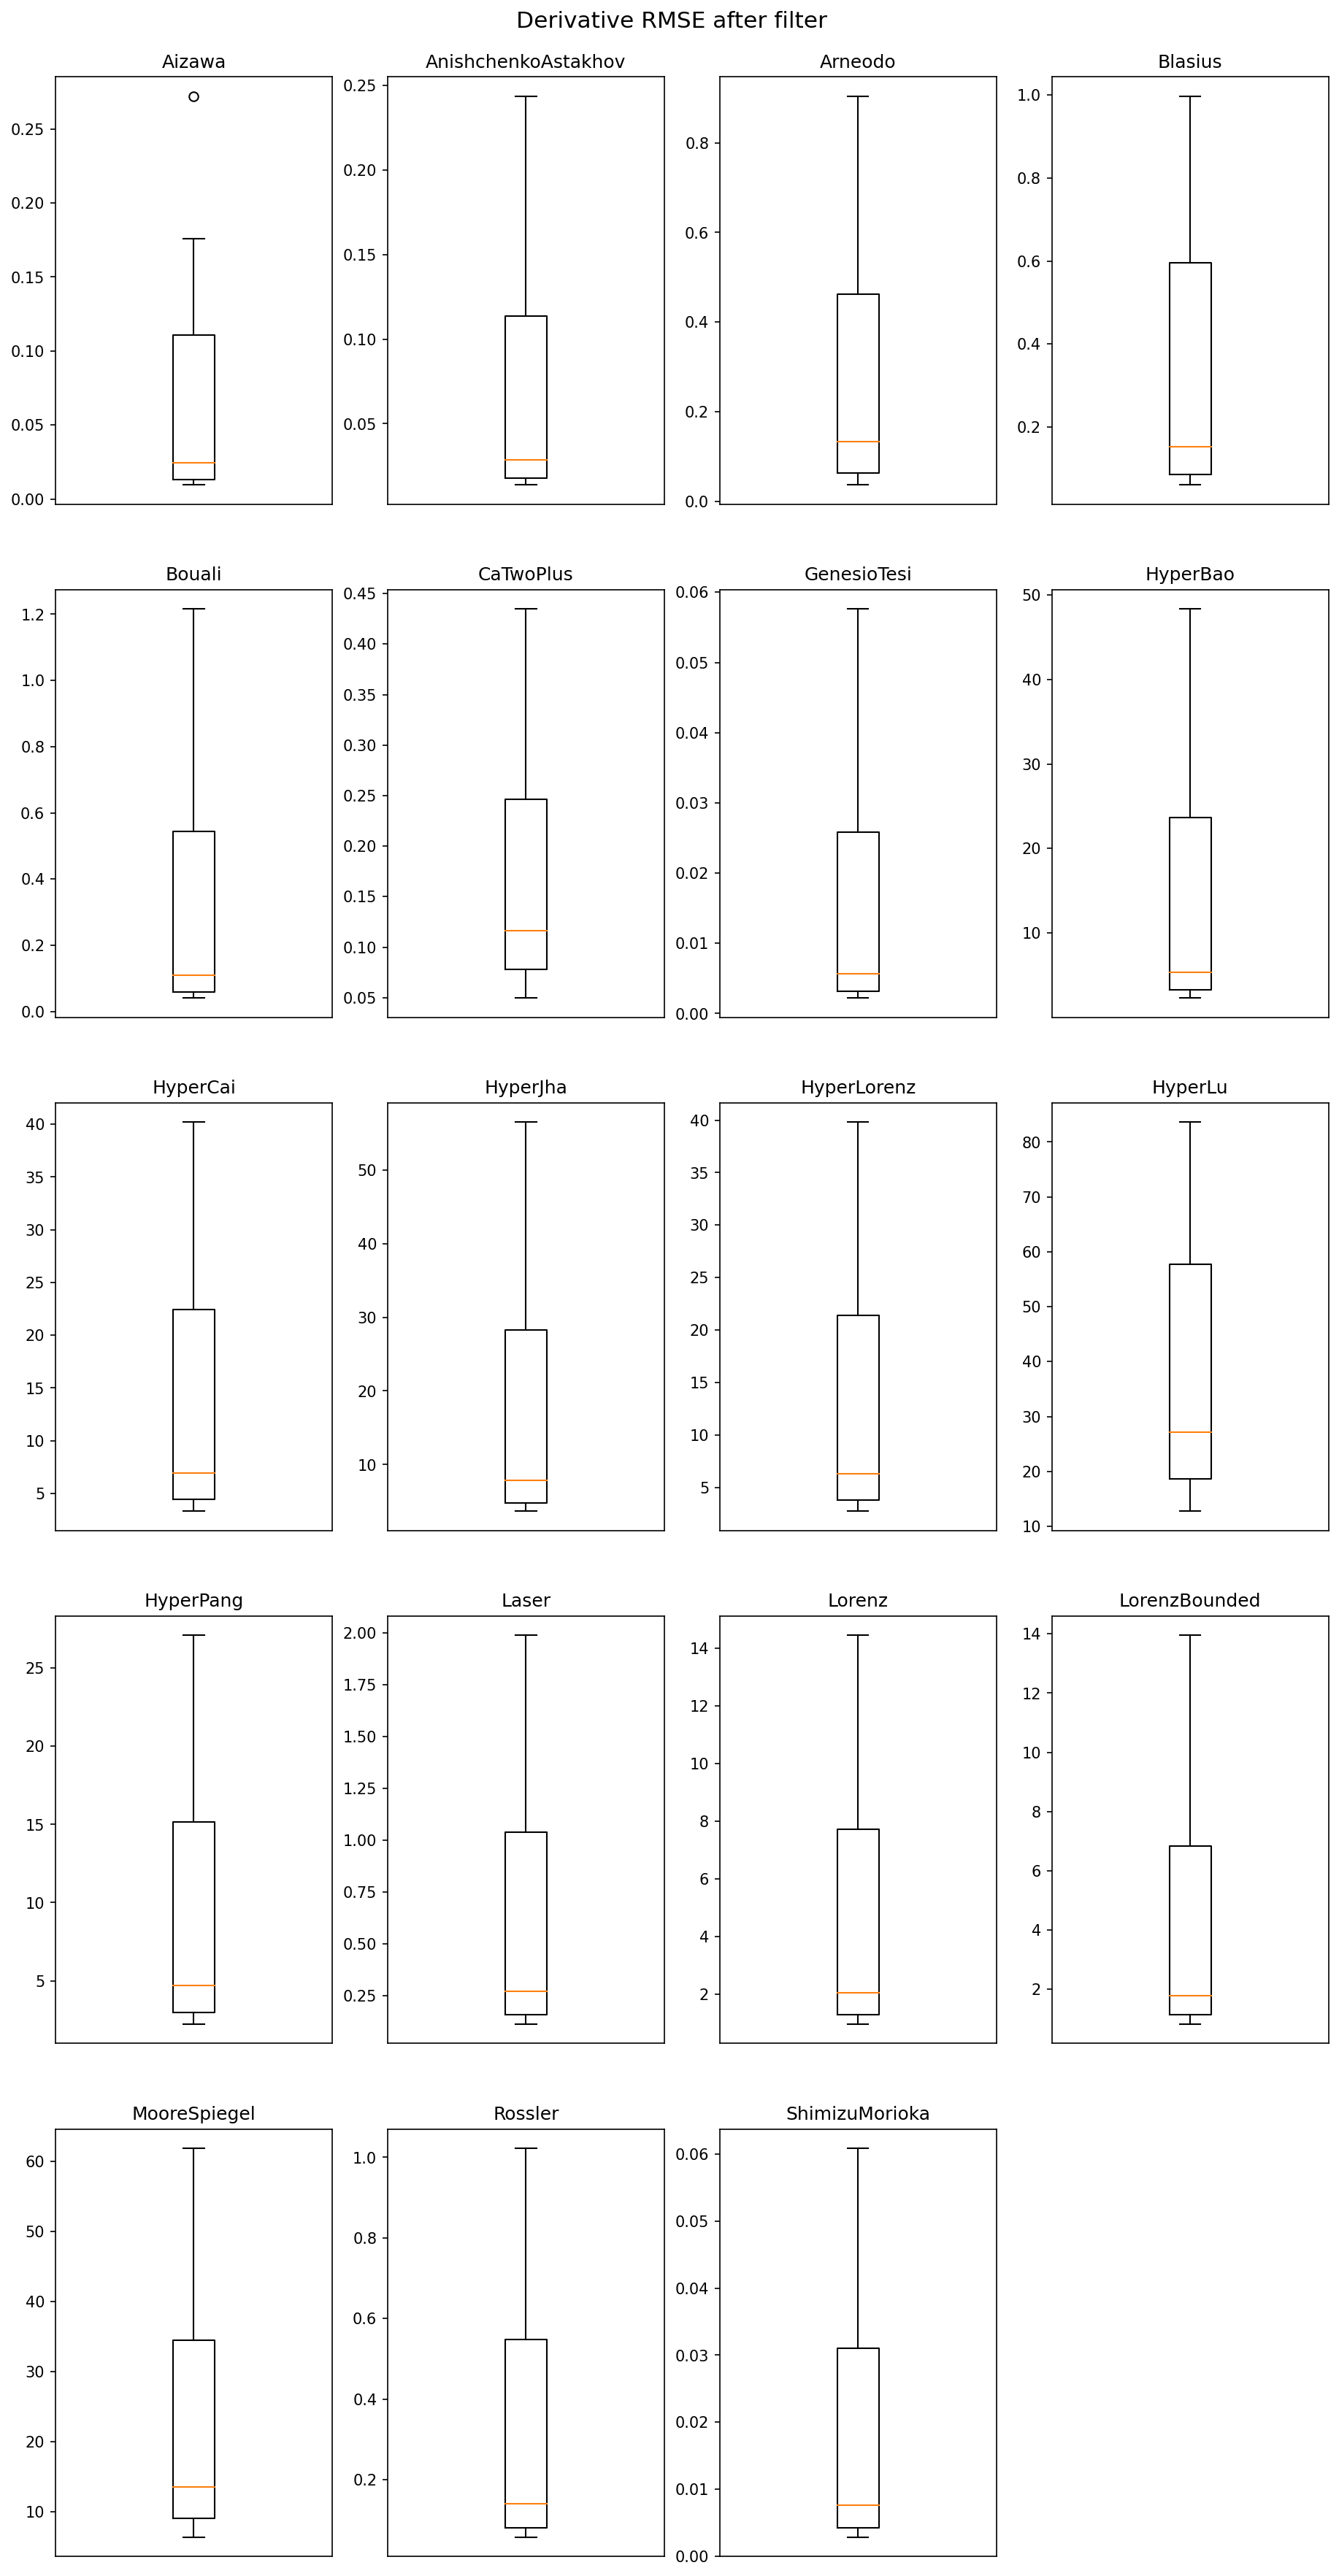

In [20]:
## filter RMES data
x_rmse_clean_dic = {}
dot_rmse_clean_dic = {}

# initialize sturctures
for system in systems_list:
    x_rmse_clean_dic[system] = list()
    dot_rmse_clean_dic[system] = list()
    
# filter and record cleaned data
for system in systems_list:
    x_rmse_clean_dic[system].extend(outlier_filter(x_rmse_dic[system]))
    dot_rmse_clean_dic[system].extend(outlier_filter(dot_rmse_dic[system]))
    
## boxplots after filter
fig, axs = plt.subplots(5, 4, figsize=(15,30))
fig.delaxes(axs[4, 3])
fig.suptitle('Origin RMSE after filter', fontsize=15, y=0.9)
fig.set_dpi(150)

for idx, system in enumerate(systems_list):
    axs[int(idx / 4), idx % 4].boxplot(x_rmse_clean_dic[system])
    axs[int(idx / 4), idx % 4].set_title(system)
    axs[int(idx / 4), idx % 4].set_xticks([], [])
    
fig, axs = plt.subplots(5, 4, figsize=(15,30))
fig.delaxes(axs[4, 3])
fig.suptitle('Derivative RMSE after filter', fontsize=15, y=0.9)
fig.set_dpi(150)

for idx, system in enumerate(systems_list):
    axs[int(idx / 4), idx % 4].boxplot(dot_rmse_clean_dic[system])
    axs[int(idx / 4), idx % 4].set_title(system)
    axs[int(idx / 4), idx % 4].set_xticks([], [])

## Normalized error for origin and derivatives before filter

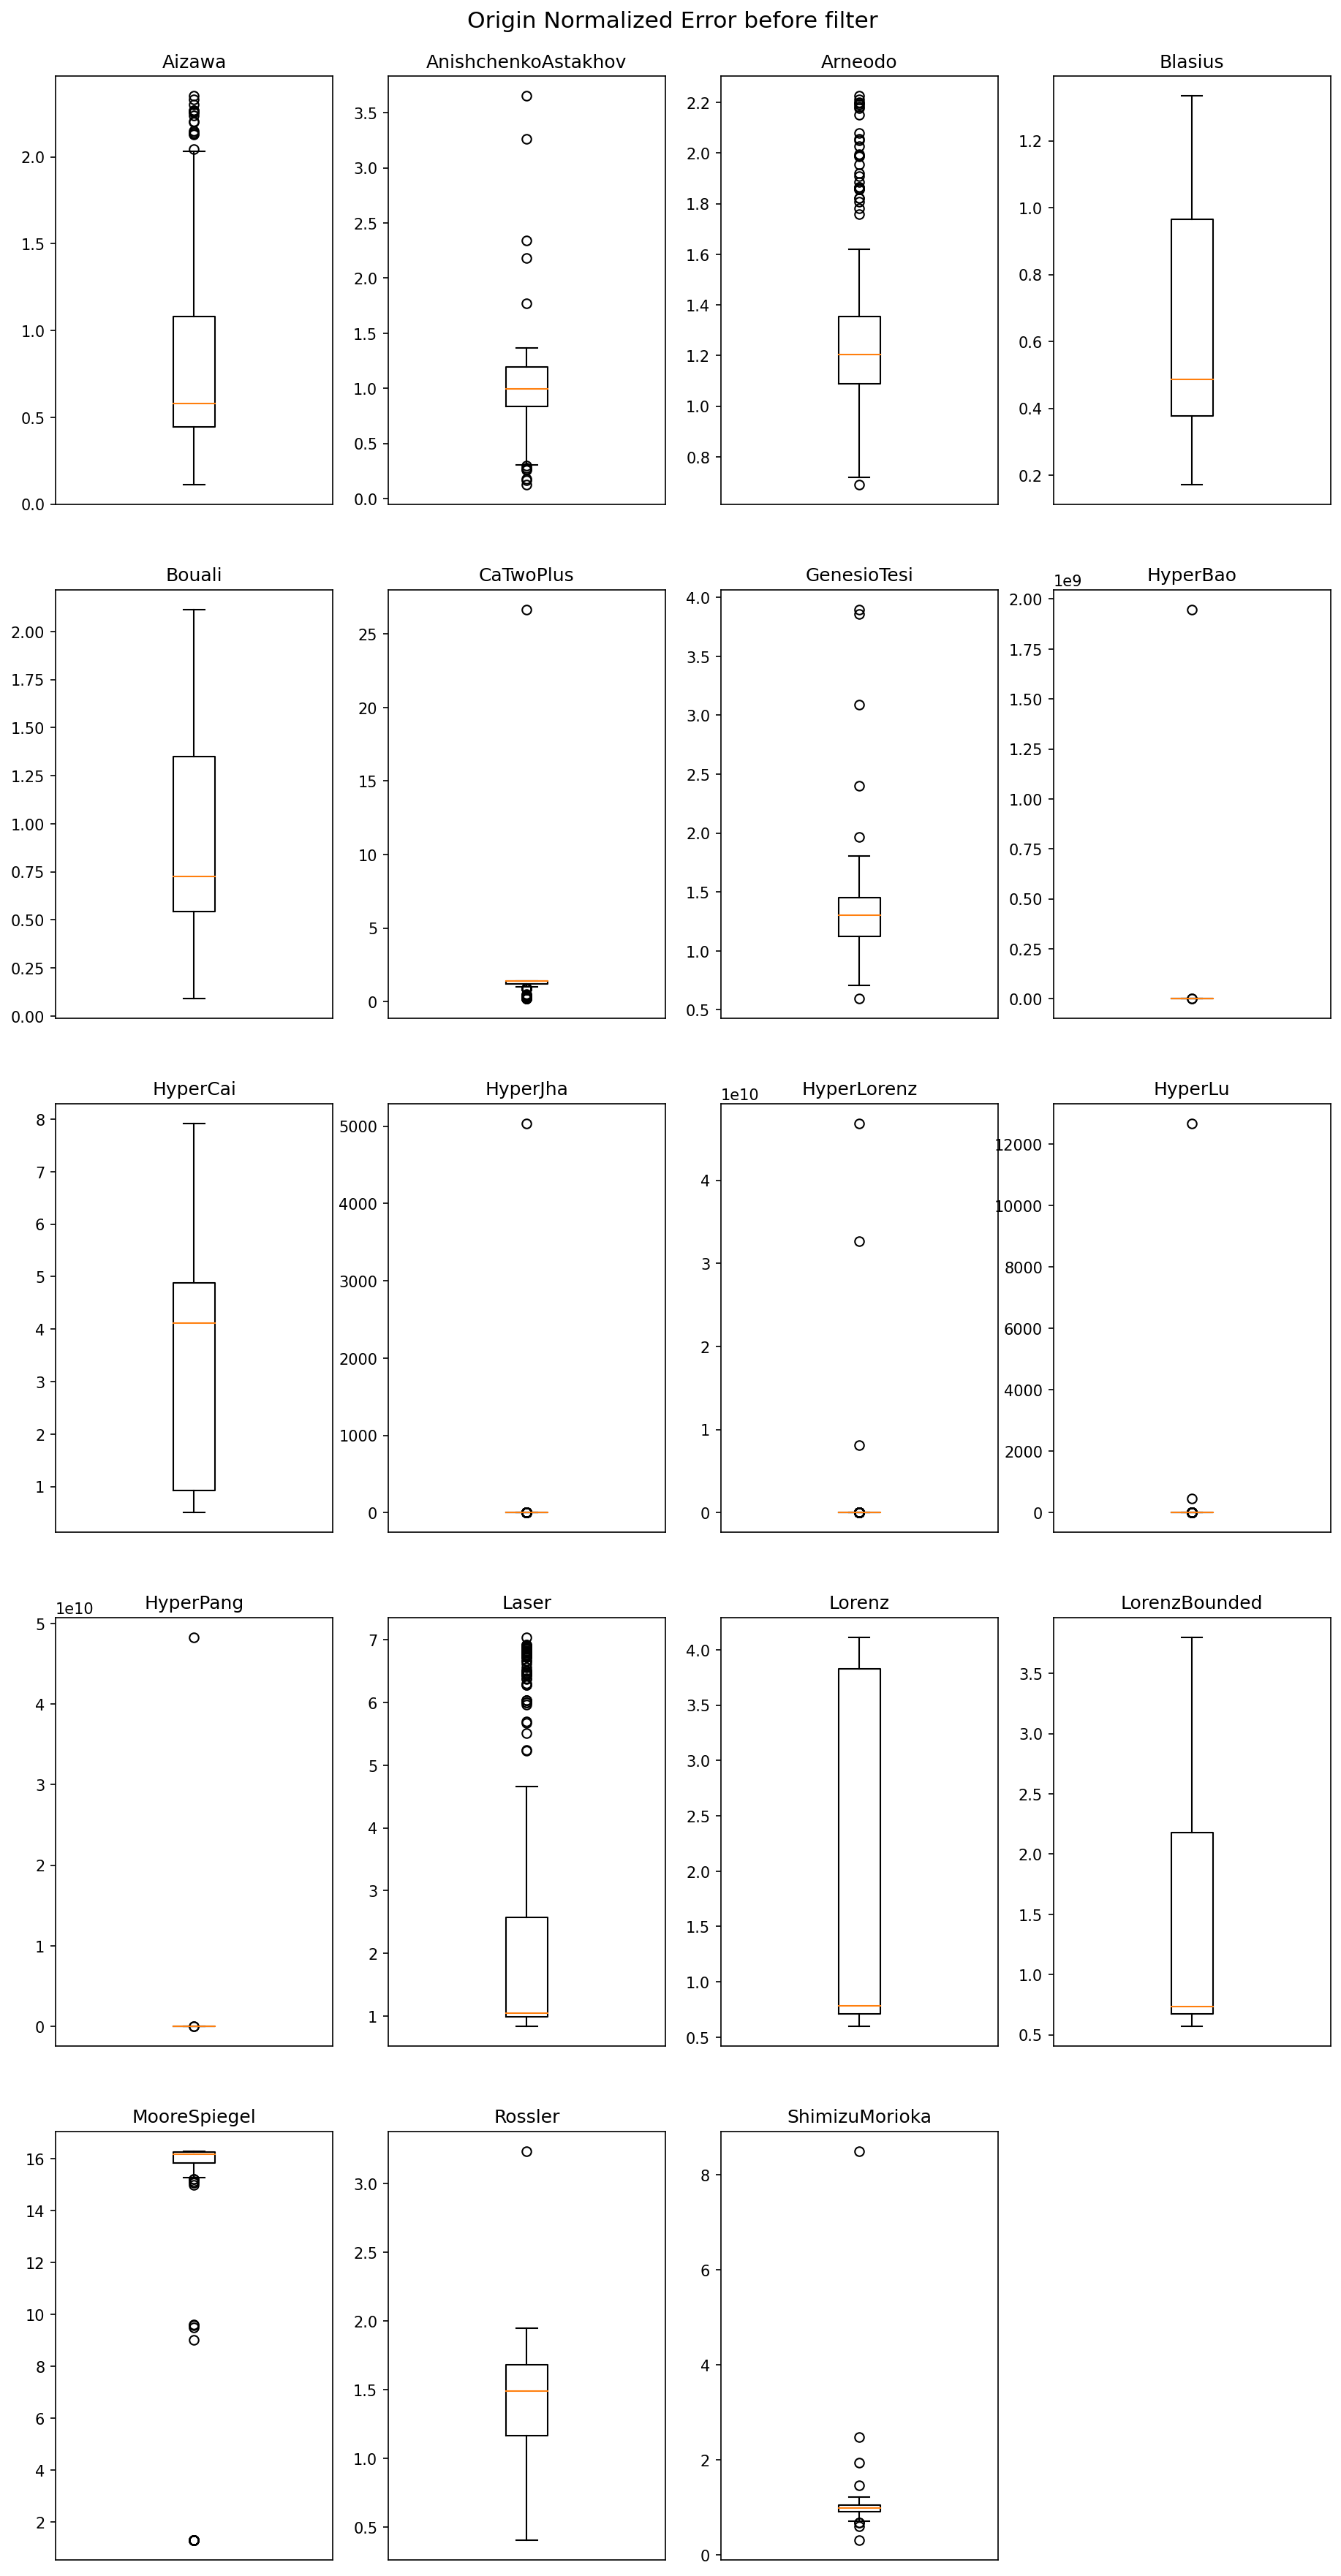

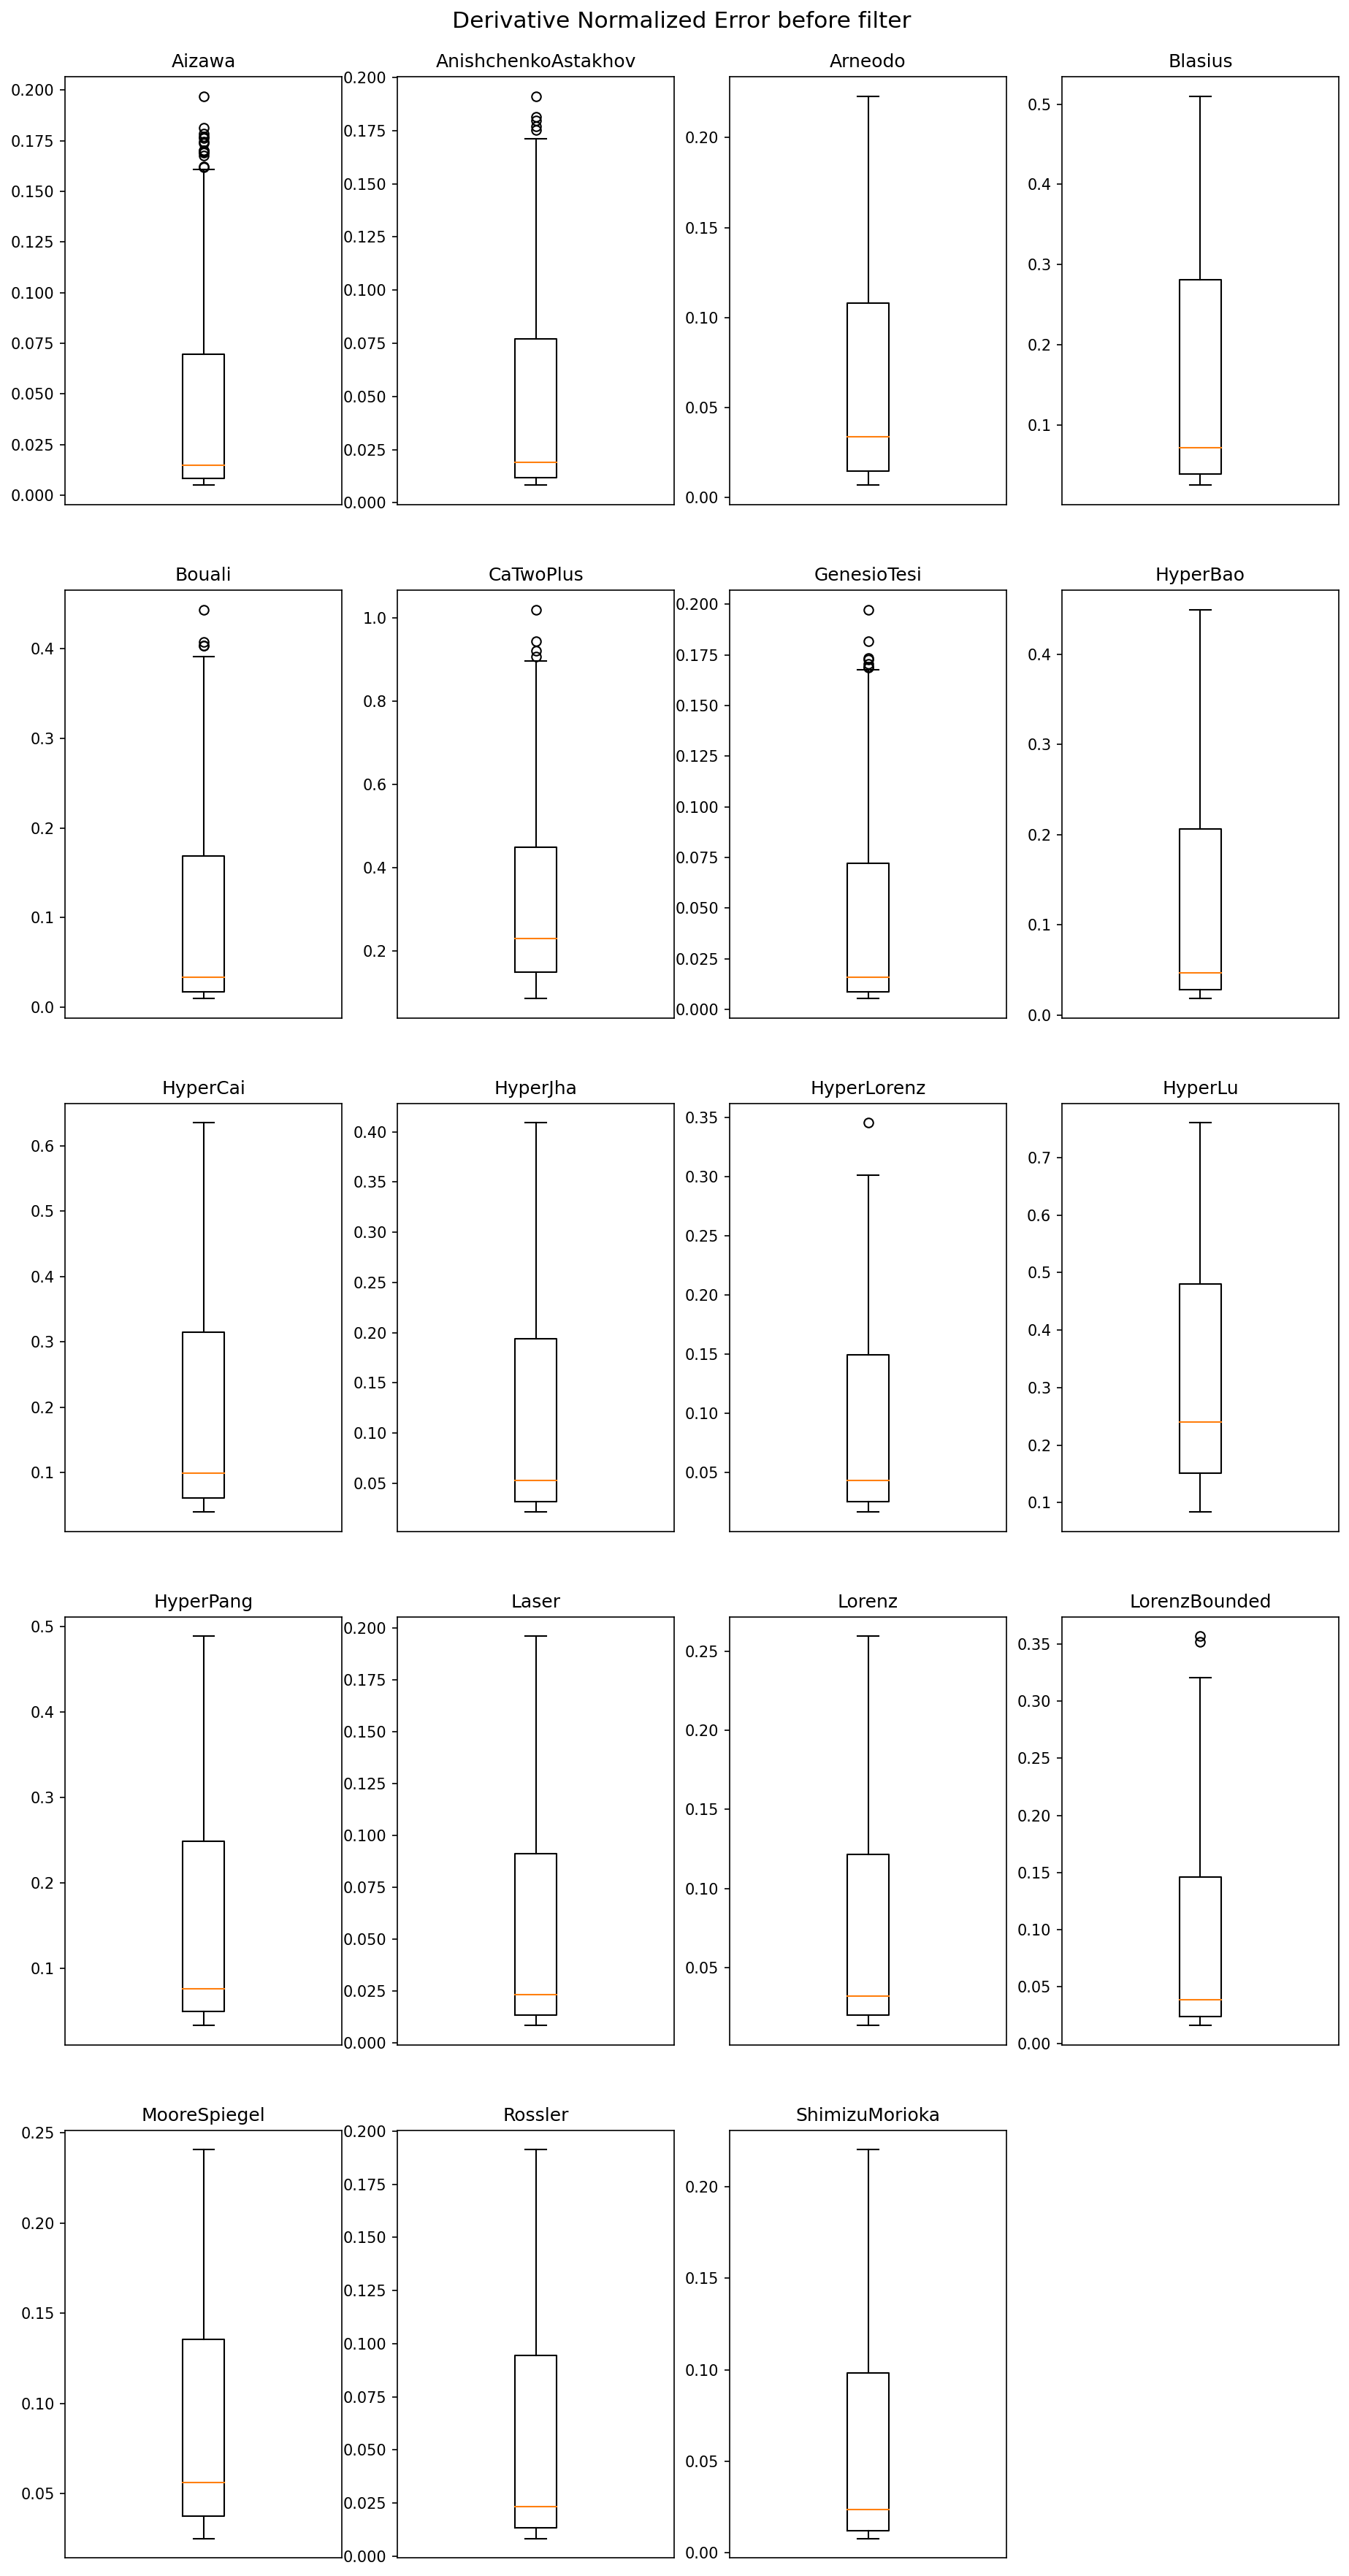

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# boxplots before filter
fig, axs = plt.subplots(5, 4, figsize=(15,30))
fig.delaxes(axs[4, 3])
fig.suptitle('Origin Normalized Error before filter', fontsize=15, y=0.9)
fig.set_dpi(150)

for idx, system in enumerate(systems_list):
    axs[int(idx / 4), idx % 4].boxplot(x_perf_dic[system])
    axs[int(idx / 4), idx % 4].set_title(system)
    axs[int(idx / 4), idx % 4].set_xticks([], [])

fig, axs = plt.subplots(5, 4, figsize=(15,30))
fig.delaxes(axs[4, 3])
fig.suptitle('Derivative Normalized Error before filter', fontsize=15, y=0.9)
fig.set_dpi(150)

for idx, system in enumerate(systems_list):
    axs[int(idx / 4), idx % 4].boxplot(dot_perf_dic[system])
    axs[int(idx / 4), idx % 4].set_title(system)
    axs[int(idx / 4), idx % 4].set_xticks([], [])


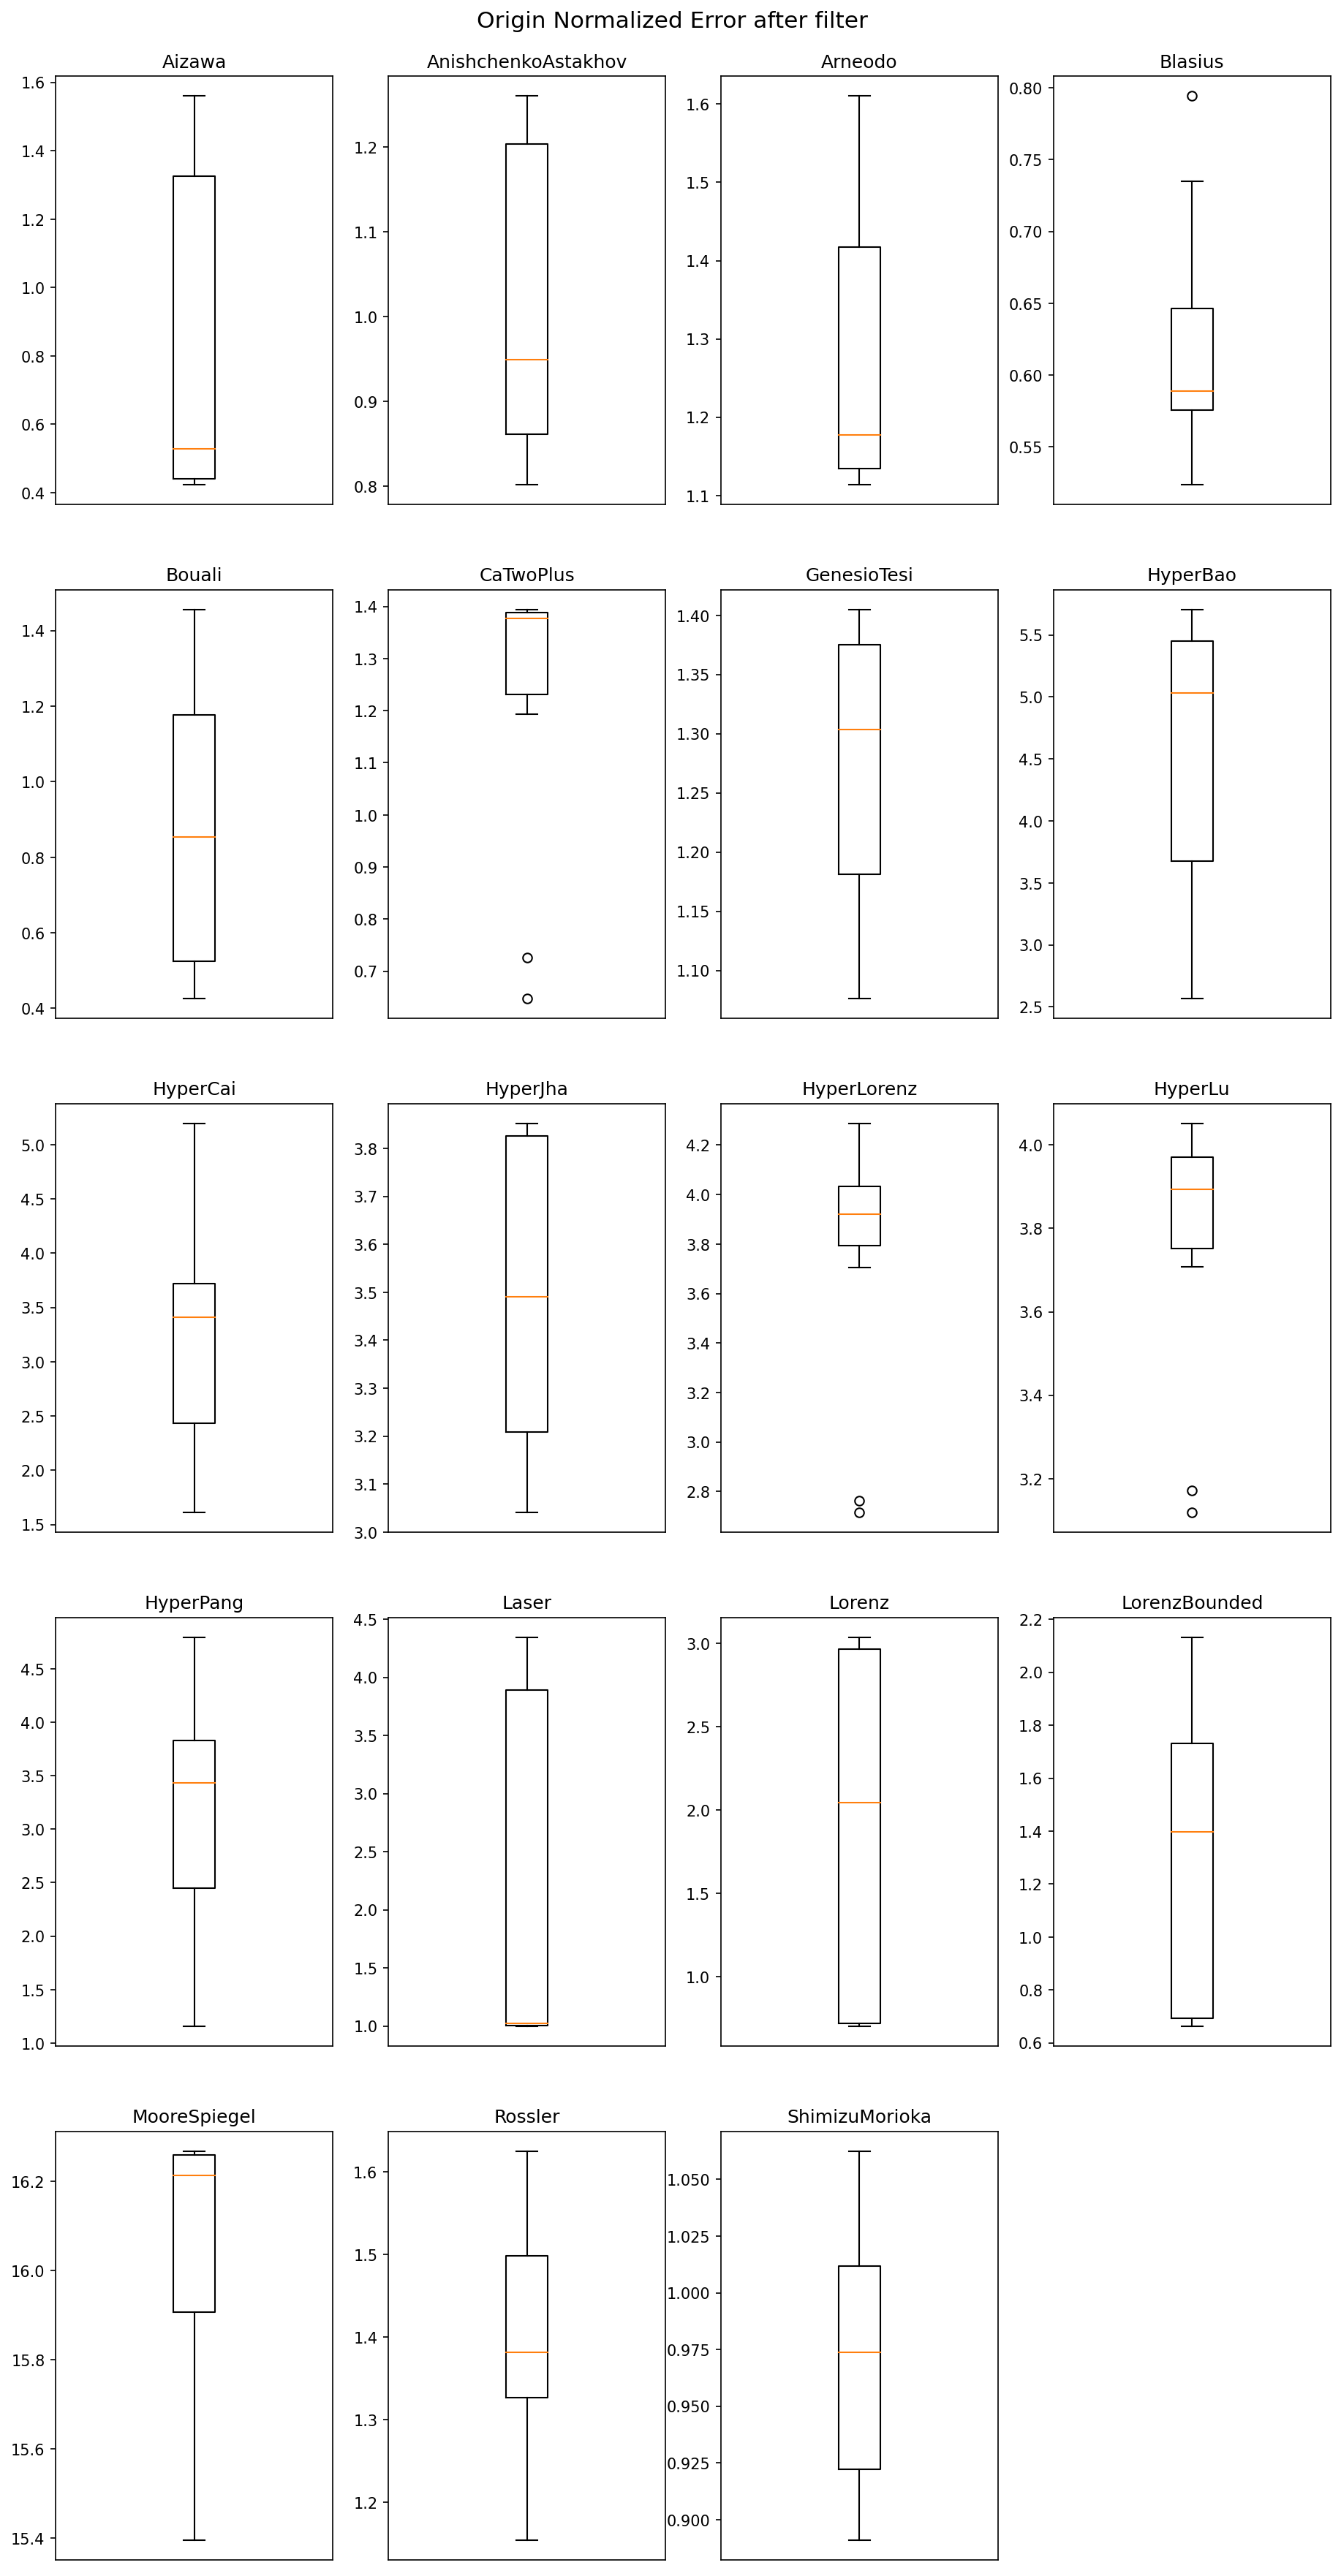

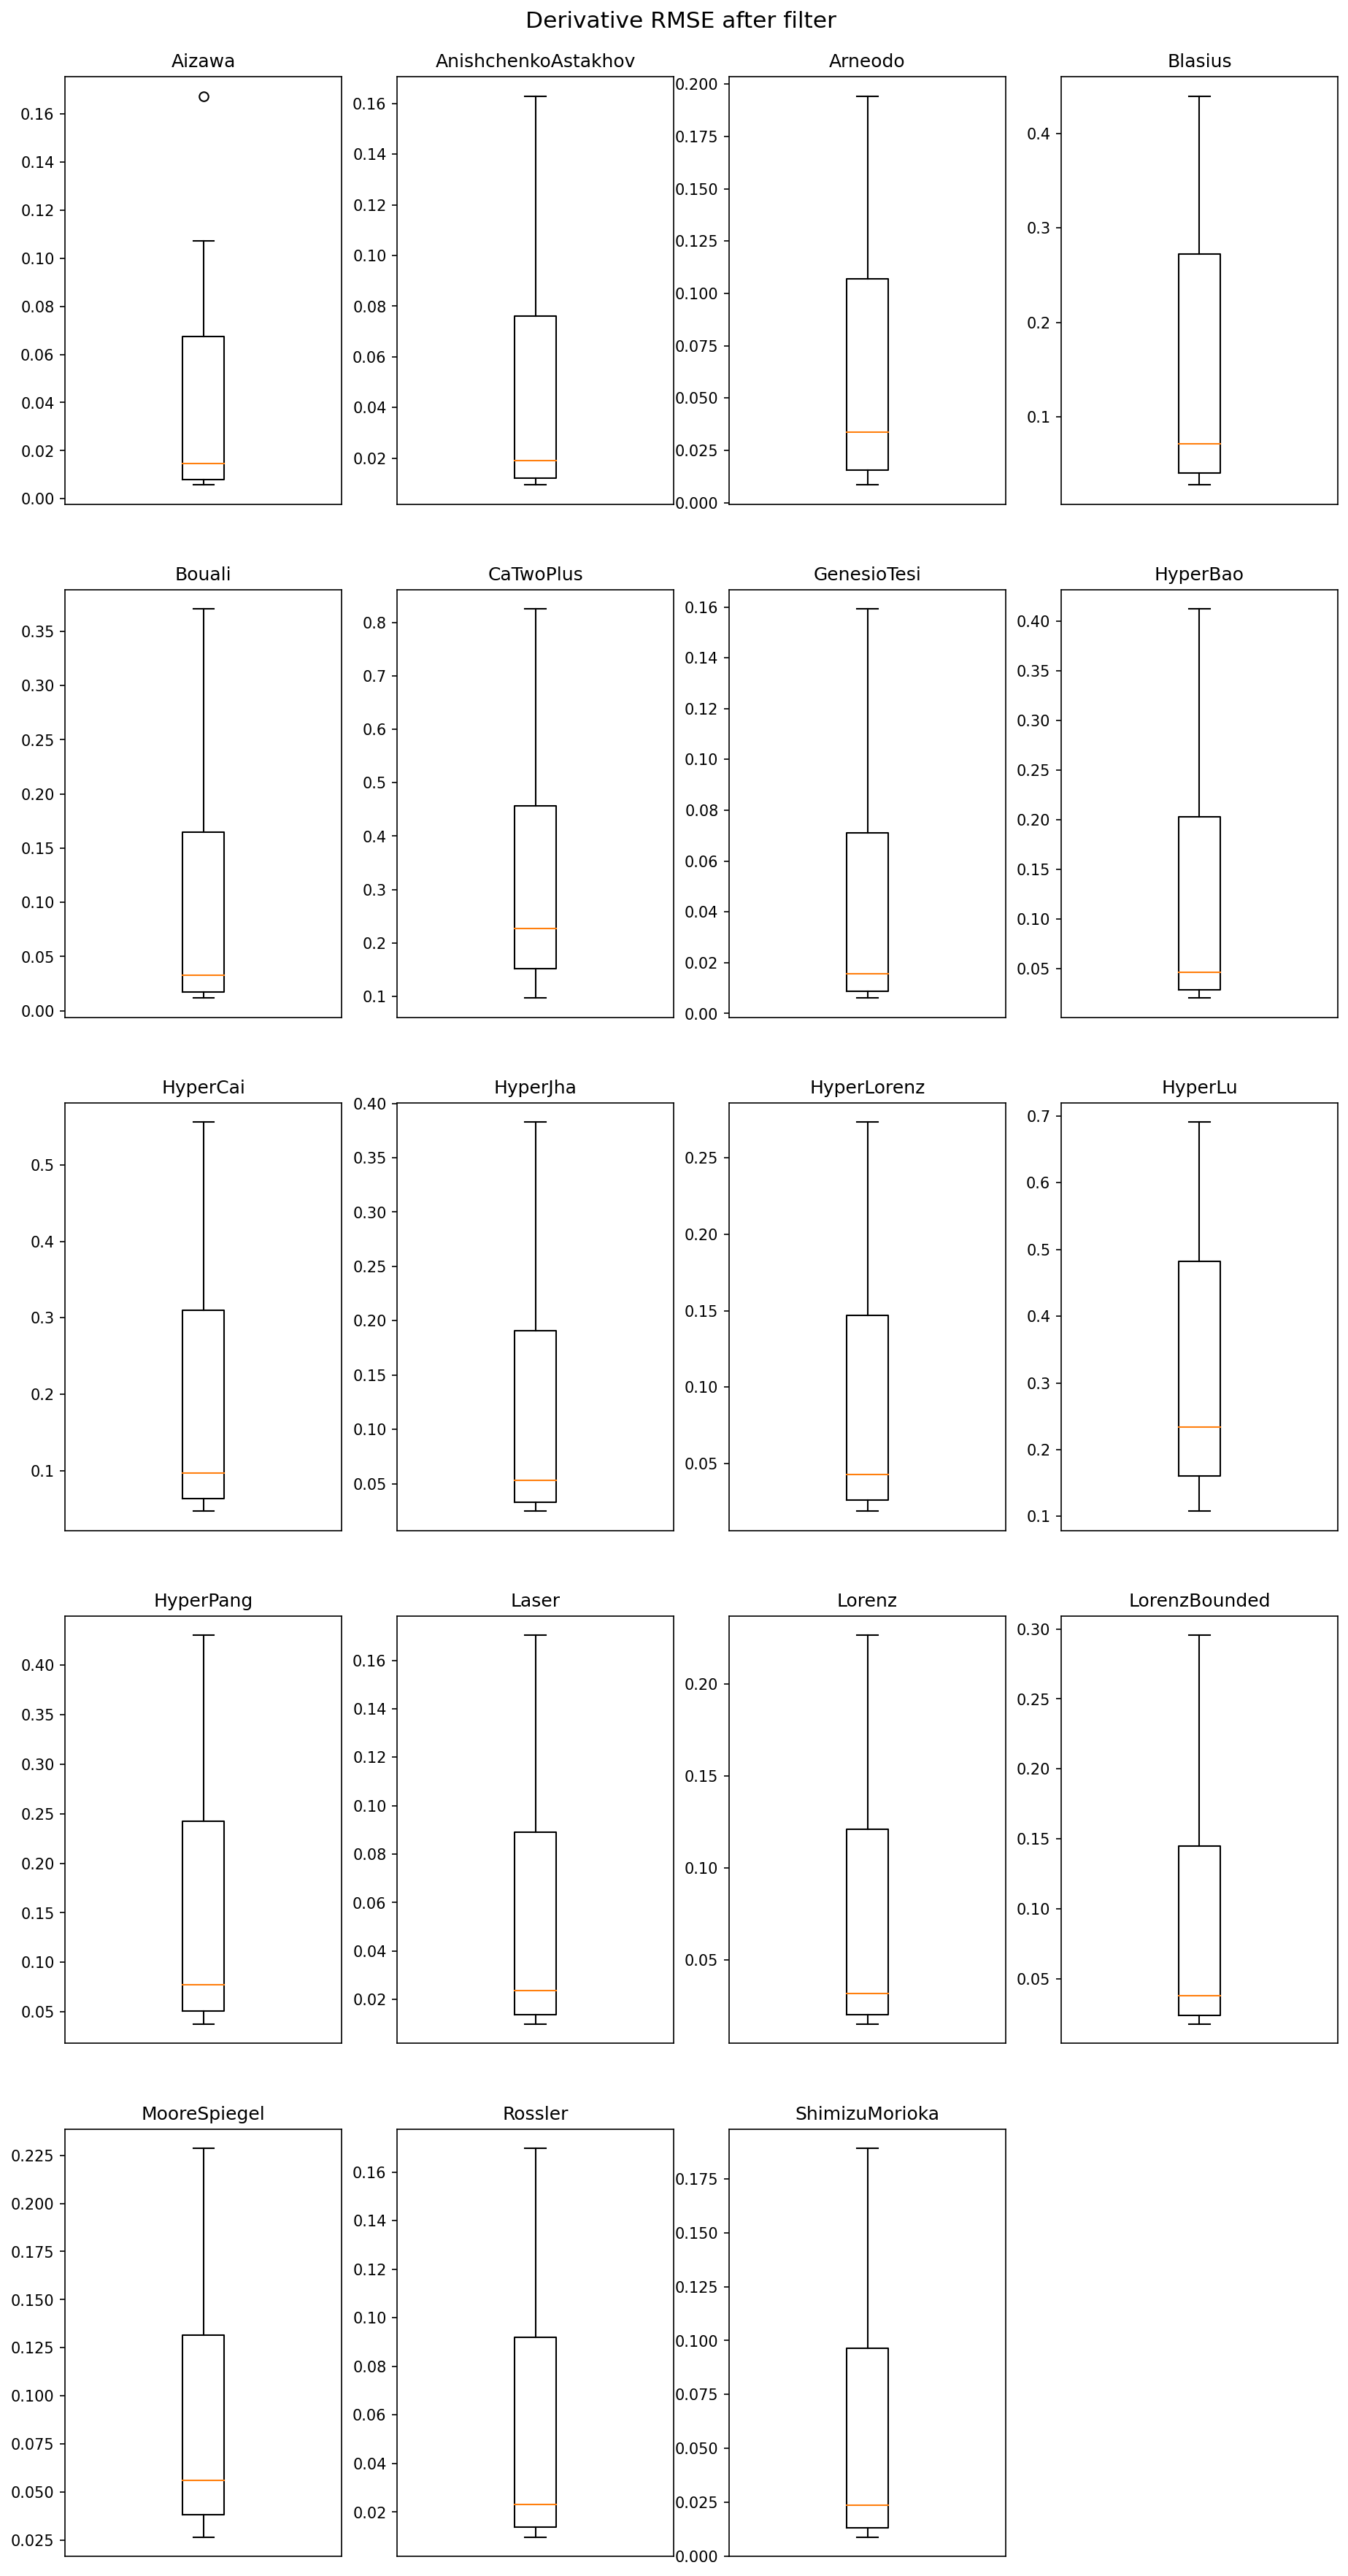

In [21]:
## filter Normalized Error data
x_perf_clean_dic = {}
dot_perf_clean_dic = {}

# initialize sturctures
for system in systems_list:
    x_perf_clean_dic[system] = list()
    dot_perf_clean_dic[system] = list()
    
# filter and record cleaned data
for system in systems_list:
    x_perf_clean_dic[system].extend(outlier_filter(x_perf_dic[system]))
    dot_perf_clean_dic[system].extend(outlier_filter(dot_perf_dic[system]))
    
## boxplots after filter
fig, axs = plt.subplots(5, 4, figsize=(15,30))
fig.delaxes(axs[4, 3])
fig.suptitle('Origin Normalized Error after filter', fontsize=15, y=0.9)
fig.set_dpi(150)

for idx, system in enumerate(systems_list):
    axs[int(idx / 4), idx % 4].boxplot(x_perf_clean_dic[system])
    axs[int(idx / 4), idx % 4].set_title(system)
    axs[int(idx / 4), idx % 4].set_xticks([], [])
    
fig, axs = plt.subplots(5, 4, figsize=(15,30))
fig.delaxes(axs[4, 3])
fig.suptitle('Derivative RMSE after filter', fontsize=15, y=0.9)
fig.set_dpi(150)

for idx, system in enumerate(systems_list):
    axs[int(idx / 4), idx % 4].boxplot(dot_perf_clean_dic[system])
    axs[int(idx / 4), idx % 4].set_title(system)
    axs[int(idx / 4), idx % 4].set_xticks([], [])

## Conclusion for filter

Based on the plots above, the filter indeed well preserve the performance distribution with increasing noise while removing the outliers based on 1.5 IQR.

Then, we use the processed data in this section to generate contour plots.

# Contour Plots

In [22]:
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

# make plot larger
plt.rcParams["figure.figsize"] = (20, 10)

In [27]:
## convert dictionary to list
x_rmse_list = []
dot_rmse_list = []

x_perf_list = []
dot_perf_list = []

for system in systems_list:
    x_rmse_list.extend(x_rmse_clean_dic[system])
    dot_rmse_list.extend(dot_rmse_clean_dic[system])
    x_perf_list.extend(x_perf_clean_dic[system])
    dot_perf_list.extend(dot_perf_clean_dic[system])

## Maximum Lyapunov Exponent

In [25]:
noisy_levels = []

for i in range(13):
    noisy_levels.append((13 - i) / 13)
    
noisy_levels = noisy_levels * 19

In [23]:
# prepare y label
lyap_e = []
for system in systems_list:
    lyap_e.append(all_properties[system]["maximum_lyapunov_estimated"])
    
# sort by lyapunov exponent
re_idx = np.argsort(lyap_e)
re_sys_list = [systems_list[i] for i in re_idx]

# assign new chaotic level uniformly in range (0, 2)
y_location = []
for i in range(len(re_sys_list)):
    y_location.append(i * 2 / len(re_sys_list))
    
# construct y coordinates for contour plot
chaotic_levels = []
for system in systems_list:
    chaotic_levels.append(y_location[re_sys_list.index(system)])
    
chaotic_levels = np.repeat(chaotic_levels, 13)

### RMSE

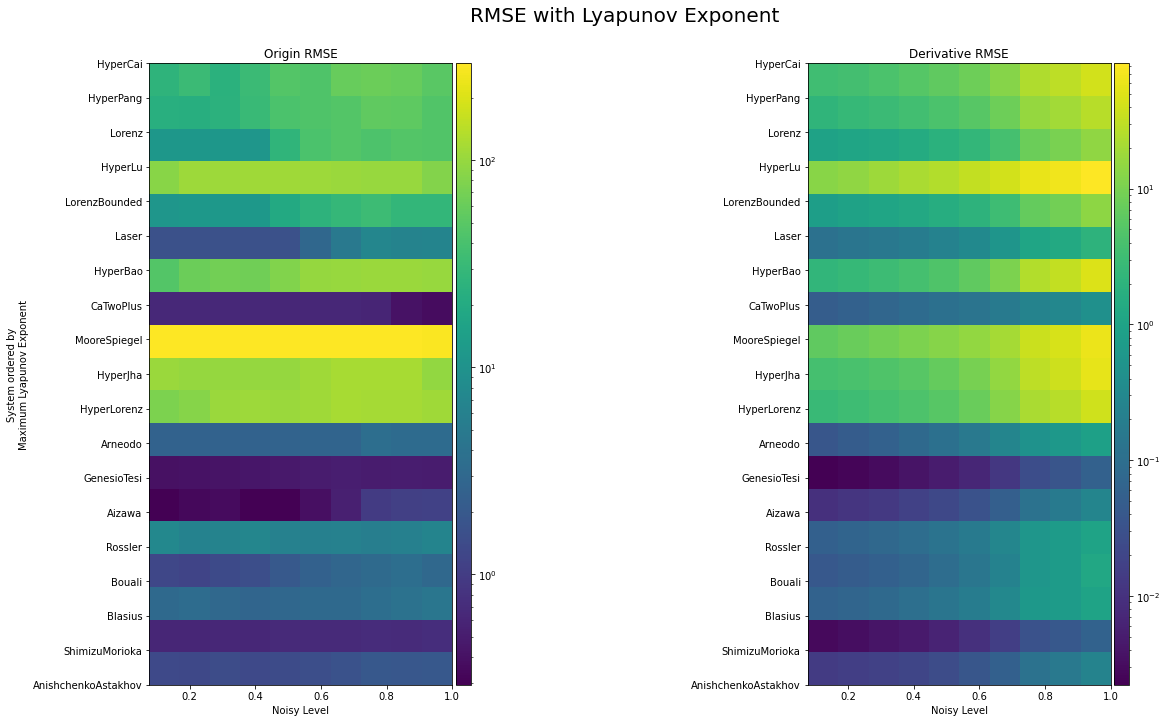

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)

## original trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), x_rmse_list, (xx, yy))

# visualize contour plot
im = ax1.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# add text descriptions
ax1.title.set_text("Origin RMSE")
ax1.set(xlabel='Noisy Level', ylabel='System ordered by\nMaximum Lyapunov Exponent')

# replace y tick
ax1.set_yticks(y_location)
ax1.set_yticklabels(re_sys_list)

## derivative trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), dot_rmse_list, (xx, yy))

# visualize contour plot
im2 = ax2.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# add text descriptions
ax2.title.set_text("Derivative RMSE")
ax2.set(xlabel='Noisy Level', ylabel='')

# replace y tick
ax2.set_yticks(y_location)
ax2.set_yticklabels(re_sys_list)

fig.suptitle('RMSE with Lyapunov Exponent', size=20, y=1)

fig.tight_layout()
fig.show()

### Normalized Error

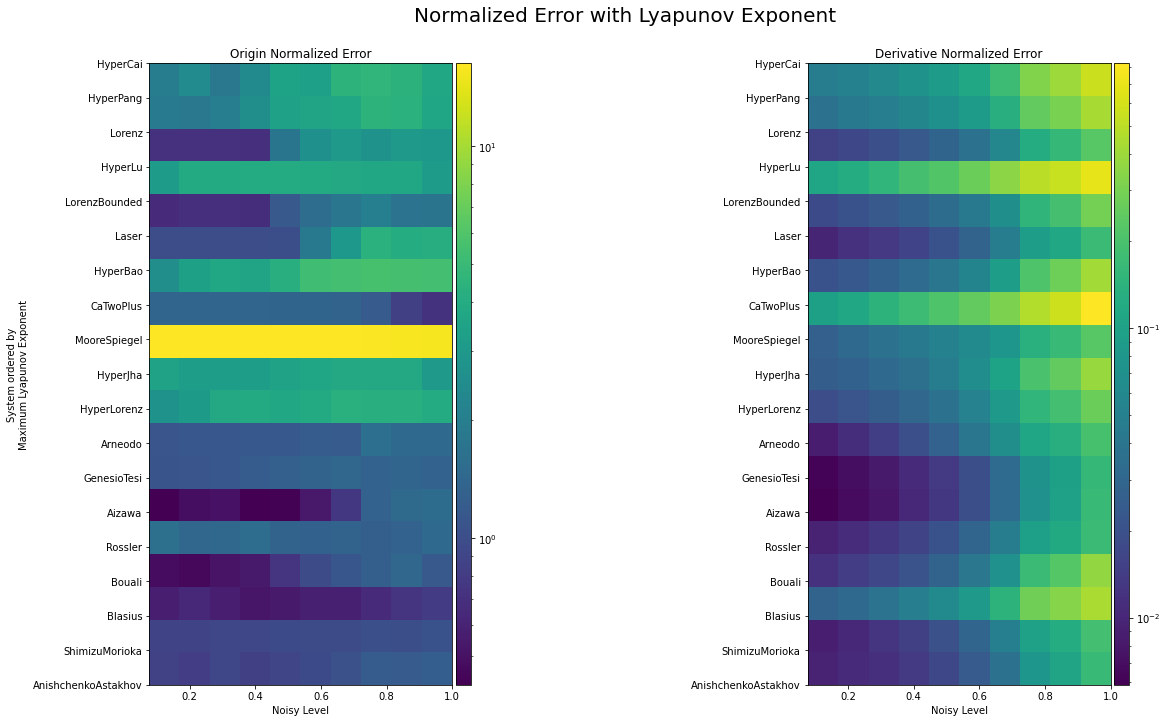

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)

## original trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), x_perf_list, (xx, yy))

# visualize contour plot
im = ax1.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# add text descriptions
ax1.title.set_text("Origin Normalized Error")
ax1.set(xlabel='Noisy Level', ylabel='System ordered by\nMaximum Lyapunov Exponent')

# replace y tick
ax1.set_yticks(y_location)
ax1.set_yticklabels(re_sys_list)

## derivative trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), dot_perf_list, (xx, yy))

# visualize contour plot
im2 = ax2.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
                 norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# add text descriptions
ax2.title.set_text("Derivative Normalized Error")
ax2.set(xlabel='Noisy Level', ylabel='')

# replace y tick
ax2.set_yticks(y_location)
ax2.set_yticklabels(re_sys_list)

fig.suptitle('Normalized Error with Lyapunov Exponent', size=20, y=1)

fig.tight_layout()
fig.show()

## Kaplan Yorke Dimension

In [31]:
# prepare y label
ky_y_list = []
for attractor_name in systems_list:
    ky_y_list.append(all_properties[attractor_name]['kaplan_yorke_dimension'])
    
# sort by lyapunov exponent
re_idx = np.argsort(ky_y_list)
re_sys_list = [systems_list[i] for i in re_idx]

# assign new chaotic level uniformly in range (0, 2)
y_location = []
for i in range(len(re_sys_list)):
    y_location.append(i * 2 / len(re_sys_list))
    
# construct y coordinates for contour plot
chaotic_levels = []
for system in systems_list:
    chaotic_levels.append(y_location[re_sys_list.index(system)])
    
chaotic_levels = np.repeat(chaotic_levels, 13)

### RMSE

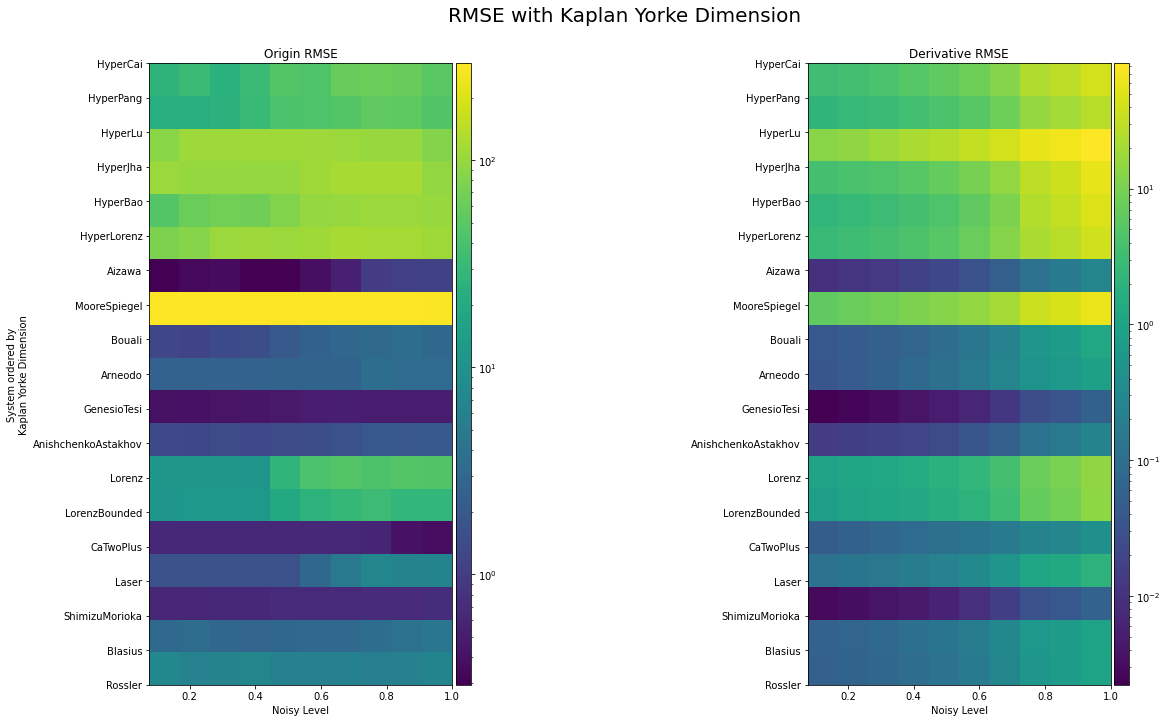

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)

## original trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), x_rmse_list, (xx, yy))

# visualize contour plot
im = ax1.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# add text descriptions
ax1.title.set_text("Origin RMSE")
ax1.set(xlabel='Noisy Level', ylabel='System ordered by\nKaplan Yorke Dimension')

# replace y tick
ax1.set_yticks(y_location)
ax1.set_yticklabels(re_sys_list)

## derivative trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), dot_rmse_list, (xx, yy))

# visualize contour plot
im2 = ax2.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
                 norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# add text descriptions
ax2.title.set_text("Derivative RMSE")
ax2.set(xlabel='Noisy Level', ylabel='')

# replace y tick
ax2.set_yticks(y_location)
ax2.set_yticklabels(re_sys_list)

fig.suptitle('RMSE with Kaplan Yorke Dimension', size=20, y=1)
fig.tight_layout()
fig.show()

### Normalized Error

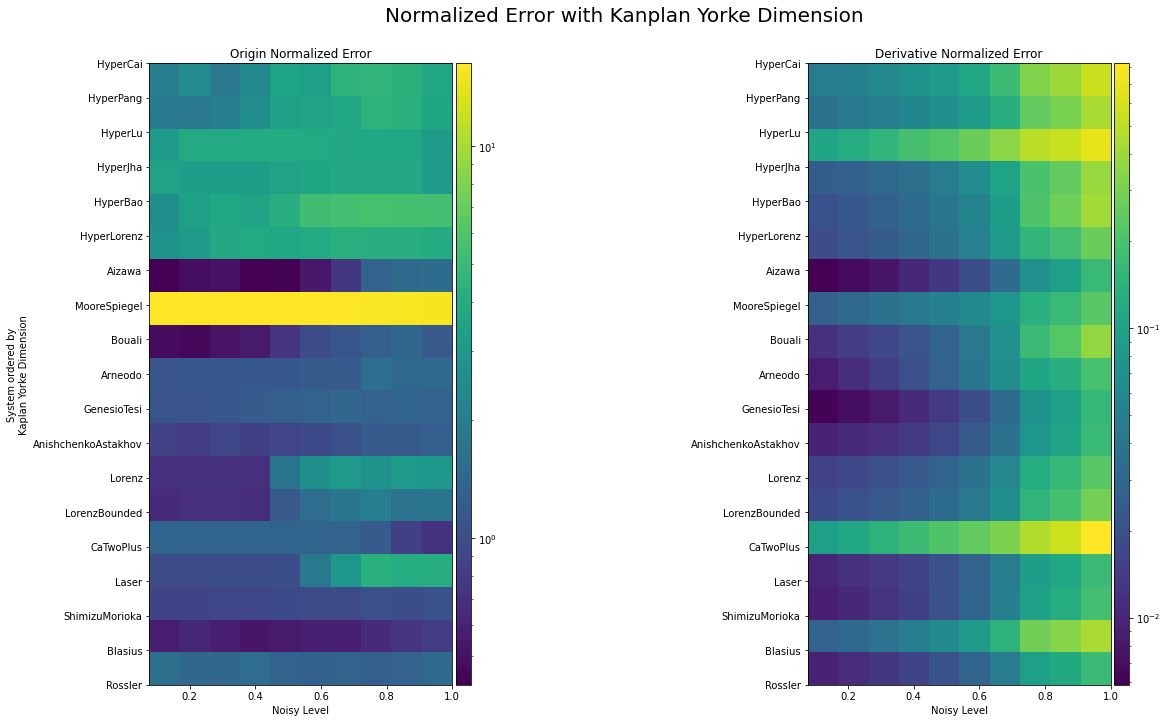

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)

## original trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), x_perf_list, (xx, yy))

# visualize contour plot
im = ax1.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# add text descriptions
ax1.title.set_text("Origin Normalized Error")
ax1.set(xlabel='Noisy Level', ylabel='System ordered by\nKaplan Yorke Dimension')

# replace y tick
ax1.set_yticks(y_location)
ax1.set_yticklabels(re_sys_list)

## derivative trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), dot_perf_list, (xx, yy))

# visualize contour plot
im2 = ax2.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
                 norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# add text descriptions
ax2.title.set_text("Derivative Normalized Error")
ax2.set(xlabel='Noisy Level', ylabel='')

# replace y tick
ax2.set_yticks(y_location)
ax2.set_yticklabels(re_sys_list)

fig.suptitle('Normalized Error with Kanplan Yorke Dimension', size=20, y=1)
fig.tight_layout()
fig.show()

## Multiscale Entropy

In [34]:
# prepare y label
entropy_y_list = []
for attractor_name in systems_list:
    entropy_y_list.append(all_properties[attractor_name]['multiscale_entropy'])
    
# sort by lyapunov exponent
re_idx = np.argsort(entropy_y_list)
re_sys_list = [systems_list[i] for i in re_idx]

# assign new chaotic level uniformly in range (0, 2)
y_location = []
for i in range(len(re_sys_list)):
    y_location.append(i * 2 / len(re_sys_list))
    
# construct y coordinates for contour plot
chaotic_levels = []
for system in systems_list:
    chaotic_levels.append(y_location[re_sys_list.index(system)])
    
chaotic_levels = np.repeat(chaotic_levels, 13)

### RMSE

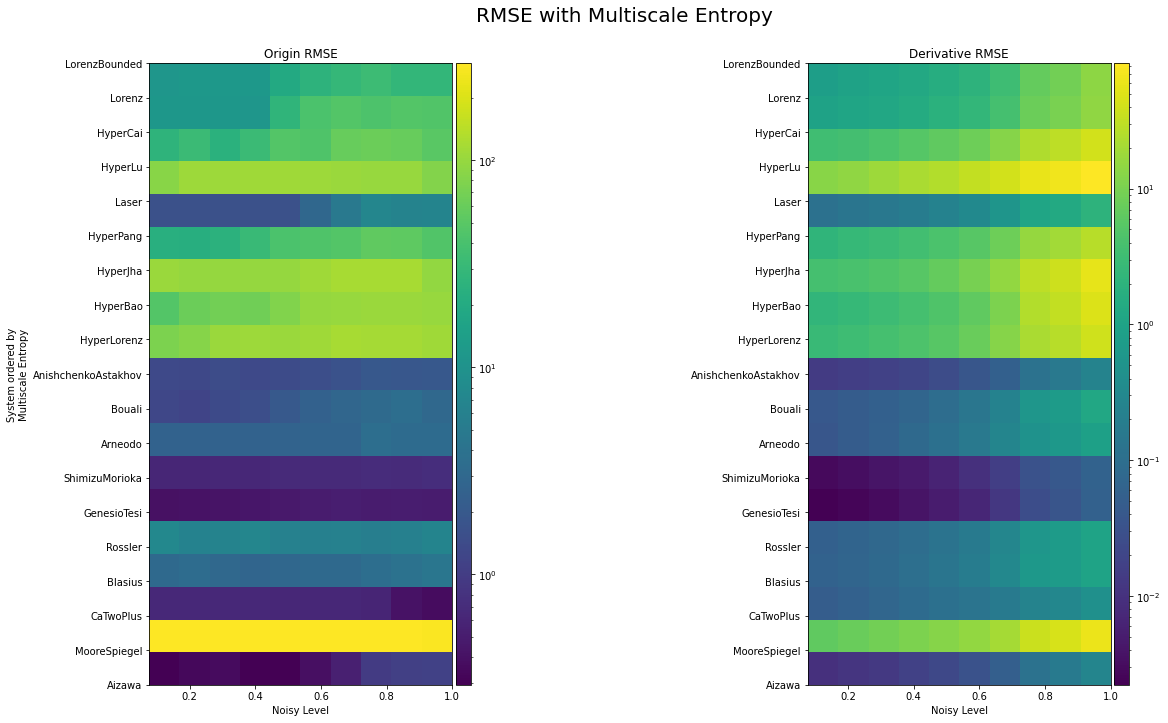

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2)

## original trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), x_rmse_list, (xx, yy))

# visualize contour plot
im = ax1.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# add text descriptions
ax1.title.set_text("Origin RMSE")
ax1.set(xlabel='Noisy Level', ylabel='System ordered by\nMultiscale Entropy')

# replace y tick
ax1.set_yticks(y_location)
ax1.set_yticklabels(re_sys_list)

## derivative trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), dot_rmse_list, (xx, yy))

# visualize contour plot
im2 = ax2.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
                 norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# add text descriptions
ax2.title.set_text("Derivative RMSE")
ax2.set(xlabel='Noisy Level', ylabel='')

# replace y tick
ax2.set_yticks(y_location)
ax2.set_yticklabels(re_sys_list)

fig.suptitle('RMSE with Multiscale Entropy', size=20, y=1)
fig.tight_layout()
fig.show()

### Normalized Error

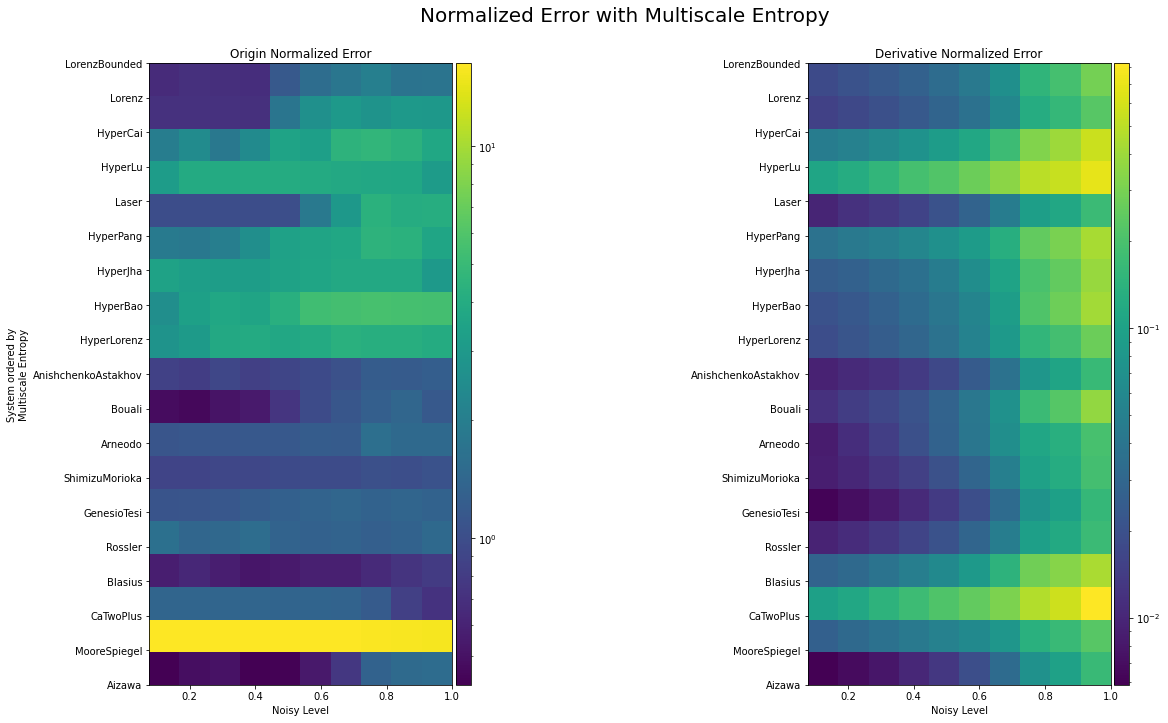

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2)

## original trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), x_perf_list, (xx, yy))

# visualize contour plot
im = ax1.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# add text descriptions
ax1.title.set_text("Origin Normalized Error")
ax1.set(xlabel='Noisy Level', ylabel='System ordered by\nMultiscale Entropy')

# replace y tick
ax1.set_yticks(y_location)
ax1.set_yticklabels(re_sys_list)

## derivative trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), dot_perf_list, (xx, yy))

# visualize contour plot
im2 = ax2.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
                 norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# add text descriptions
ax2.title.set_text("Derivative Normalized Error")
ax2.set(xlabel='Noisy Level', ylabel='')

# replace y tick
ax2.set_yticks(y_location)
ax2.set_yticklabels(re_sys_list)

fig.suptitle('Normalized Error with Multiscale Entropy', size=20, y=1)
fig.tight_layout()
fig.show()

## Correlation Dimenison

In [37]:
# prepare y label
dimension_y_list = []
for attractor_name in systems_list:
    dimension_y_list.append(all_properties[attractor_name]['correlation_dimension'])
    
# sort by lyapunov exponent
re_idx = np.argsort(dimension_y_list)
re_sys_list = [systems_list[i] for i in re_idx]

# assign new chaotic level uniformly in range (0, 2)
y_location = []
for i in range(len(re_sys_list)):
    y_location.append(i * 2 / len(re_sys_list))
    
# construct y coordinates for contour plot
chaotic_levels = []
for system in systems_list:
    chaotic_levels.append(y_location[re_sys_list.index(system)])
    
chaotic_levels = np.repeat(chaotic_levels, 13)

### RMSE

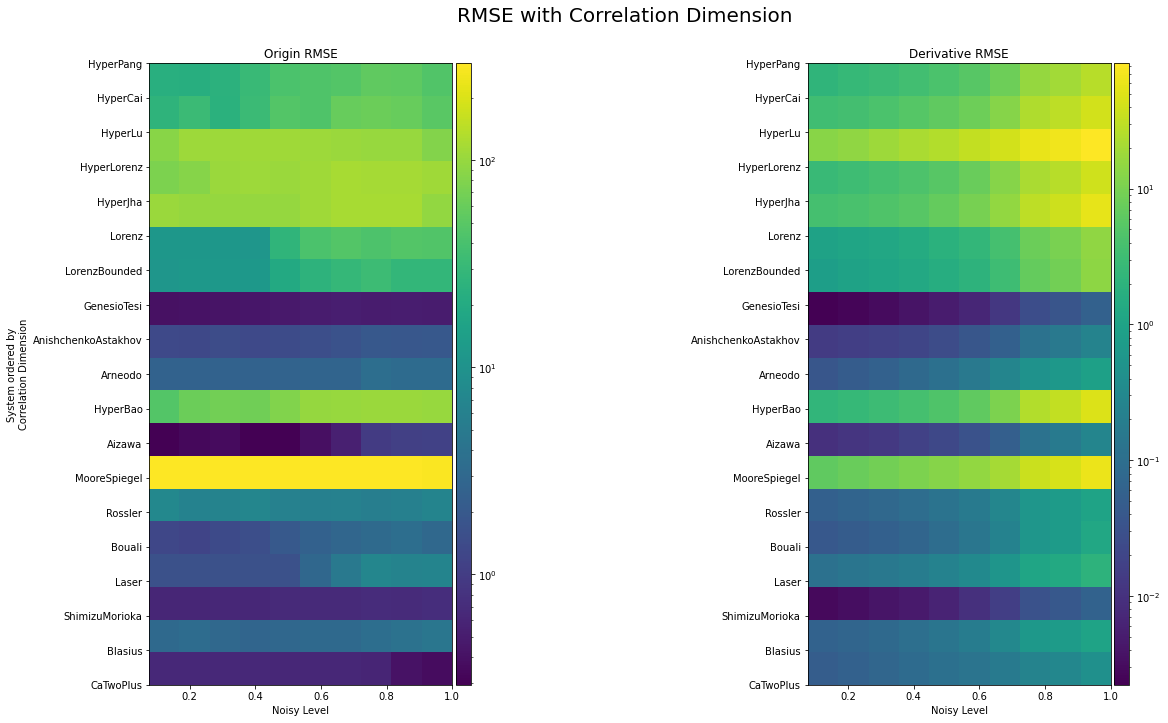

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)

## original trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), x_rmse_list, (xx, yy))

# visualize contour plot
im = ax1.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# add text descriptions
ax1.title.set_text("Origin RMSE")
ax1.set(xlabel='Noisy Level', ylabel='System ordered by\nCorrelation Dimension')

# replace y tick
ax1.set_yticks(y_location)
ax1.set_yticklabels(re_sys_list)

## derivative trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), dot_rmse_list, (xx, yy))

# visualize contour plot
im2 = ax2.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# add text descriptions
ax2.title.set_text("Derivative RMSE")
ax2.set(xlabel='Noisy Level', ylabel='')

# replace y tick
ax2.set_yticks(y_location)
ax2.set_yticklabels(re_sys_list)

fig.suptitle('RMSE with Correlation Dimension', size=20, y=1)
fig.tight_layout()
fig.show()

### Normalized Error

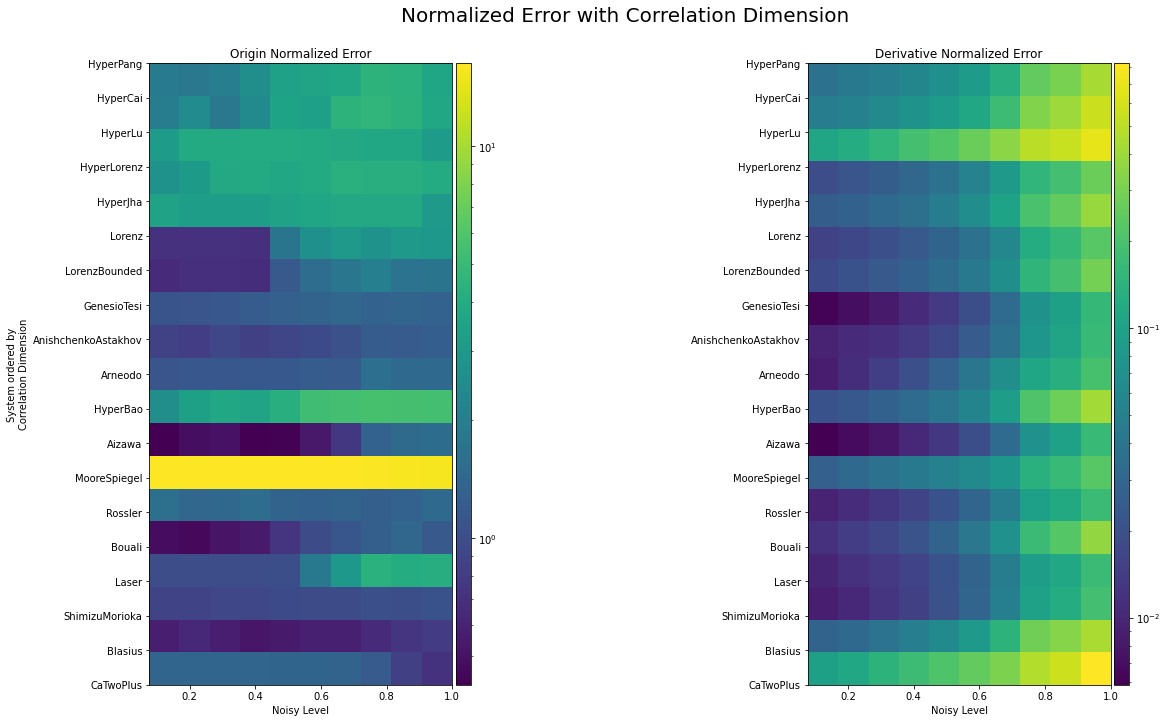

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2)

## original trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), x_perf_list, (xx, yy))

# visualize contour plot
im = ax1.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# add text descriptions
ax1.title.set_text("Origin Normalized Error")
ax1.set(xlabel='Noisy Level', ylabel='System ordered by\nCorrelation Dimension')

# replace y tick
ax1.set_yticks(y_location)
ax1.set_yticklabels(re_sys_list)

## derivative trajectory
# form data grid for plotting
xx, yy = np.meshgrid(np.linspace(np.amin(noisy_levels), np.amax(noisy_levels), 10),
                     np.linspace(np.amin(chaotic_levels), np.amax(chaotic_levels), 19))
zz = griddata((noisy_levels, chaotic_levels), dot_perf_list, (xx, yy))

# visualize contour plot
im2 = ax2.imshow(zz, extent=(np.amin(noisy_levels), np.amax(noisy_levels), 
                           np.amin(chaotic_levels), np.amax(chaotic_levels)),
               norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# add text descriptions
ax2.title.set_text("Derivative Normalized Error")
ax2.set(xlabel='Noisy Level', ylabel='')

# replace y tick
ax2.set_yticks(y_location)
ax2.set_yticklabels(re_sys_list)

fig.suptitle('Normalized Error with Correlation Dimension', size=20, y=1)
fig.tight_layout()
fig.show()